Just s,a,r
https://tomroth.com.au/dqn-simple/
https://markus-x-buchholz.medium.com/deep-reinforcement-learning-introduction-deep-q-network-dqn-algorithm-fb74bf4d6862

Using images
https://towardsdatascience.com/deep-q-network-with-pytorch-146bfa939dfe

In [ ]:
val = np.array([1,2,3,4])
print(np.argmax(val))

3


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import itertools
import time
from google.colab import output
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

Building NN net

In [2]:
num_actions = 7
#input_dim -> num of values in single state 1D or 3D
model = Sequential()
model.add(Dense(64,input_dim = 1, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(num_actions,activation='linear'))
model.compile(optimizer=Adam(), loss='mse')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 2,439
Trainable params: 2,439
Non-trainable params: 0
_________________________________________________________________


Some initial parameters

In [4]:
num_ep = 10
gamma = 0.99
epsilon = 1
minibatch_size = 32
rew_sums = [] #stores rew for each episode
replay_memory1 = []
replay_memory2 = [] #stores s,a,r,s'
max_mem_size = 100000

In [32]:
paretoList = [[27.365007703242995, 20.09975124224178],
 [27.039658301585717, 20.09975124224178],
 [27.641096998130227, 20.09975124224178],
 [26.55654914700754, 22.0],
 [25.97042057904419, 22.0],
 [25.38885062374585, 22.0],
 [24.81217606567878, 22.0]]

'''
paretoList = [[89.00031518164273, 65.86349520030045], [89.89961557343754, 64.389440128021], [89.43403953083185, 65.09992319503918],[83.5136611195402, 70.74602462329597],[88.9499343220807, 62.58828725834597],[89.08999189433153, 65.09992319503918], [89.05258736962958, 65.19202405202648],
 [89.07676981971224, 65.19202405202648], [87.02821495153329, 66.2117814289874], [89.08999189433153, 65.09992319503918], [89.05258736962958, 65.19202405202648],
 [89.07676981971224, 65.19202405202648], [87.02821495153329, 66.2117814289874], [86.80154054413104, 67.06713054842886], [83.84557463726141, 68.67313885355759], [83.69564109874385, 69.93568473962345],
 [83.5136611195402, 70.74602462329597],[90.01796235821872, 64.45153217728807], [89.50734353211787, 65.19202405202648], [89.55265145339347, 65.12296062065974], [89.53981905286764, 65.14598989960932], [88.9499343220807, 66.58828725834597],
 [87.69924734468235, 66.94027188471824], [87.10191723850293, 68.10286337592568], [84.32989997720018, 69.49820141557622], [84.11251564639825, 70.07139216541941], [84.17822101381995, 70.74602462329597],
 [83.54051281048423, 72.20110802473879], [83.86133969184611, 70.80254232723568]]

'''

'\nparetoList = [[89.00031518164273, 65.86349520030045], [89.89961557343754, 64.389440128021], [89.43403953083185, 65.09992319503918],[83.5136611195402, 70.74602462329597],[88.9499343220807, 62.58828725834597],[89.08999189433153, 65.09992319503918], [89.05258736962958, 65.19202405202648],\n [89.07676981971224, 65.19202405202648], [87.02821495153329, 66.2117814289874], [89.08999189433153, 65.09992319503918], [89.05258736962958, 65.19202405202648],\n [89.07676981971224, 65.19202405202648], [87.02821495153329, 66.2117814289874], [86.80154054413104, 67.06713054842886], [83.84557463726141, 68.67313885355759], [83.69564109874385, 69.93568473962345],\n [83.5136611195402, 70.74602462329597],[90.01796235821872, 64.45153217728807], [89.50734353211787, 65.19202405202648], [89.55265145339347, 65.12296062065974], [89.53981905286764, 65.14598989960932], [88.9499343220807, 66.58828725834597],\n [87.69924734468235, 66.94027188471824], [87.10191723850293, 68.10286337592568], [84.32989997720018, 69.4982

In [33]:
len(paretoList)

7

In [34]:


S=[[] for i in range(0,len(paretoList))]
front = [[]]
front_val = [[]]
n=[0 for i in range(0,len(paretoList))]
rank = [0 for i in range(0, len(paretoList))]
append1 = []
append2 = []
append3 = []
append4 = []
append5 = []
for p in range(0, len(paretoList)):
  #n[p] = 0
  #S[p] = []
  
  for q in range(0, len(paretoList)):
    #if(e[1]<each[1] and e[0]<=each[0]) or (e[1]<=each[1] and e[0]<each[0]):
    if (p!=q):
      if ((paretoList[p][0]<paretoList[q][0] and paretoList[p][1]<=paretoList[q][1])
      or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<paretoList[q][1])): #p dominates q
        if q not in S[p]: #new added line
          S[p].append(q)
          append1.append(paretoList[p])
      elif ((paretoList[p][0]>paretoList[q][0] and paretoList[p][1]>=paretoList[q][1])
      or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>paretoList[q][1])): #p dominates q
        n[p] = n[p] + 1
        append2.append(paretoList[q])
    
  if n[p] == 0:
    rank[p] = 0   #modified to 0 from 1
    if p not in front[0]:  #adding distinct solutions to first front
      front[0].append(p)
      front_val[0].append(paretoList[p])
      #paretoList.remove(paretoList[p])
      append3.append(paretoList[p])

    
i = 0
print('fronts',front[0])
while (front[i] != []): #not empty
  Q_P = []
  Q_Pval = []
  #print('front',i,'',front[i])
  
  for p in front[i]:
    #print('S[p]',p,S[p])
    for q in S[p]:
      n[q] = n[q] - 1
      if (n[q] == 0):
        rank[q] = i+1
        if q not in Q_P:
          Q_P.append(q)
          Q_Pval.append(paretoList[q])
          #paretoList.remove(paretoList[q])
          append4.append(paretoList[p])
    
  i = i+1
  front.append(Q_P)
  front_val.append(Q_Pval)
  #append4 += 1
        
              
del front[len(front)-1]
del front_val[len(front_val)-1]

print(len(front_val))

fronts [1, 6]
4


In [ ]:
paretoList[]

[1.5500938466242948, 1.0]

In [ ]:
paretoList[14]

[89.53981905286764, 65.14598989960932]

In [ ]:
S

[[3], [2, 3], [3], []]

In [36]:
front_val[0]

[[27.039658301585717, 20.09975124224178], [24.81217606567878, 22.0]]

In [ ]:
import matplotlib.pyplot as plt


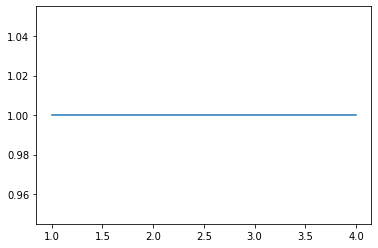

In [ ]:
x = [1,2,3,4]
y=[1,1,1,1]
plt.plot(x,y)

2.42
1.31


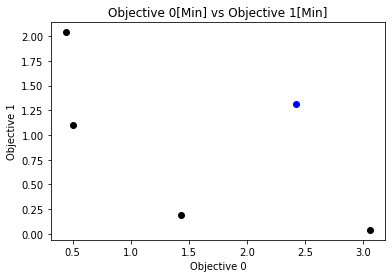

In [ ]:
a=[]

for i in range(len(front_val[0])):
  x = front_val[0][i][0]
  
  y = front_val[0][i][1]
  plt.scatter(x,y,c='black')


for i in range(len(front_val[1])):
  x = front_val[1][i][0]
  y = front_val[1][i][1]
  plt.scatter(x,y,c='blue')
plt.title('Objective 0[Min] vs Objective 1[Min]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])
print(x)
print(y)

In [ ]:
front_val

[[[83.5136611195402, 70.74602462329597],
  [88.9499343220807, 62.58828725834597]],
 [[89.00031518164273, 65.86349520030045],
  [89.89961557343754, 64.389440128021],
  [89.43403953083185, 65.09992319503918]]]

In [ ]:
len(paretoList)

2

In [ ]:
np.random.randn(1,4)*(20)

array([[ -2.72924009, -12.26950151,   4.77931521,  -4.85581415]])

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class GreenHouseEnv(object):
  def __init__(self,m,n,o):  #m, n and o is the dimension of the grid
    #self.grid = np.zeros((m,n))
    self.m = m
    self.n = n
    self.o = o
    self.occupied = []
    self.statePosDict ={}
    self.statePositionDict(m,n,o)
    #self.obsSpace = [[[k for k in range(self.o)] for j in range(self.n)] for i in range(self.m)]
    self.obsSpace = [i for i in range(self.m * self.n * self.o)]
    #print(self.obsSpace)
    self.actSpace = {'U': 0, 'D': 1, 'L': 2, 'R': 3, 'B': 4, 'F': 5}
    self.possibleAct = ['U','D','L','R', 'B', 'F']
    self.addComponents()
    self.rules_arr_rew = [9999,9999,0,0,9999,9999]
    self.objectives_comp_1 = {
        1: 'heater',
        2: 'water tank'
    }
    self.env_pos_log = []
    self.rew_vec = [99999,0,0,0,99999,99999] #6 is number of objectives
    self.log_d = {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.log_best_d =  {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.rew_obtained =  {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.best_pos = [999,999,999]
    self.best_pos_2 = [0,0]
    self.best_pos_3 = [0,0]
    self.best_pos_4 = [0,0]
    self.best_pos_5 = [999,999]
    self.best_pos_6 = [999,999]
    self.best_pos_log_2 =  []
    self.best_pos_log_3 =  []
    self.best_pos_log_4 =  []
    self.best_pos_log_5 =  []
    self.best_pos_log_6 =  []
    self.best_pos_log =  []
    self.prev_distance = [99999,0,0,0,99999,99999] #to keep record of the prev distance
  
  def addComponents(self):
    self.components = [1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8,9,10]

    if len(self.components)> self.m*self.n*self.o:
      print('errorrrr')
      return 0

    
    self.comp_dictionary = {
        1: 'heater',
        2: 'water tank',
        3: 'pack soil',
        4: 'heat sensor',
        5: 'camera',
        6: 'fan',
        7: 'led',
        8: 'water pump',
        9: 'PCB',
        10: 'Pipes'
    }

    #self.grid = np.zeros((self.m,self.n,self.o))
    #print('grid: 111', self.grid)  
    
    len_com = len(self.components)
    i = 0
    while len_com != 0:
      #print('i',i)
      x = random.choice(range(0,self.m))
      y = random.choice(range(0,self.n))
      z = random.choice(range(0,self.o))
      if (x,y,z) not in self.occupied:
        #self.grid[x,y,z] = components[i]
        self.occupied.append((x,y,z))
        len_com -= 1
        i += 1
      

      #else:
      #  x = random.choice(range(0,self.m))
      #  y = random.choice(range(0,self.n))
      #  z = random.choice(range(0,self.o))
      #  self.grid[x,y,z] = components[i]
      #  self.occupied.append((x,y,z))
    #print('grid: ', np.shape(self.grid))   
    print('occupied:',self.occupied)

  def getComponentPosition(self, index):
    return self.occupied[index]

  def getComponentValue(self, pos):
    if pos in self.occupied:
      id = self.occupied.index(pos)
      val = self.components[id]
    else:
      val = -1
    return val

  def setState(self, state, comp_id):
    x,y,z = self.getComponentPosition(comp_id)
    #self.grid[x,y,z] = -1
    x,y,z = state
    #self.grid[x,y,z] = components[comp_id]
    self.occupied[comp_id] = state

  def totalDistance(self, components):
    total_dist = 0
    for i in range(len(components)):
      for j in range(len(components)):
        i_pos = self.getComponentPosition(i+1)
        j_pos = self.getComponentPosition(j+1)
        dist_temp = self.calcDistance(i_pos, j_pos)
        total_dist += dist_temp

    return total_dist


  def obj1(self):
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)


    
    #rule 1 - minimize distance between pack soil, water tank and water pump
    #if component == 2 or component == 3 or component == 8:
    print('RULE 1')
    d1 = self.calcDistance(1,2)
    d2 = self.calcDistance(2,7)
    d3 = self.calcDistance(1,7)
    avg_d = (d1 + d2 + d3)/3
    #print('avg',avg_d)
      
    temp_rew_vec[0] = avg_d

    #find diff from last distance and new distance
    diff_1 = avg_d - self.rew_vec[0]
    diff_2 = self.prev_distance[0] - self.rew_vec[0]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if avg_d>self.prev_distance[0]: # move away
      rew_comp[0] = -1
    elif avg_d<self.prev_distance[0]: # move closer
      #if it moves closer then check for the best score
      if avg_d<self.rew_vec[0]: #set a new best score
        rew_comp[0] = 10
        self.rew_vec[0] = avg_d
        pos1 = self.getComponentPosition(1)
        pos2 = self.getComponentPosition(2)
        pos3 = self.getComponentPosition(7)
        self.best_pos = [pos1, pos2, pos3]
        self.best_pos_log.append(self.best_pos)
      elif avg_d==self.rew_vec[0]: #find a similar best score
        rew_comp[0] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[0] = 2
    elif avg_d==self.prev_distance[0]: # stay in same place
      rew_comp[0] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[0] = avg_d
      
    '''
      if avg_d<self.rew_vec[0]:
        rew_comp[0] = 1
        self.rew_vec[0] = avg_d
        
      elif avg_d>self.rew_vec[0]:
        rew_comp[0] = -20
      else:
        rew_comp[0] = 0
      '''
    self.log_d[0].append(avg_d)
    self.log_best_d[0].append(self.rew_vec[0])
    self.rew_obtained[0].append(rew_comp[0])
    print('score obtained',rew_comp[0])
    print('avg_d', avg_d)
    print('slf.rew_vec', self.rew_vec[0])
    print('reward',rew_comp[0])
      
      #total += rew1
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[0], 'new dist:', avg_d ,'rew1:', rew1)
    '''
    #rule 2 - minimize distance between heater and the fan
    if component == 1 or component == 6:
      #print('RULE 2')
      #print(self.rules_arr_rew)
      hf = self.calcDistance(0,5)
      #print('dist',hf)
      
      temp_rew_vec[1] = hf
      if hf<self.rew_vec[1]:
        rew_comp[1] = 1
        
      elif hf > self.rew_vec[1]:
        rew_comp[1] = -1
      else:
        rew_comp[1] = 0
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[1],'new dist:', hf , 'rew2:', rew2)

    #rule 3 - maximize distance between LED and heat sensor
    if component == 4 or component == 7:
      #print('RULE 3')
      lhs = self.calcDistance(3,6)
      
      temp_rew_vec[2] = lhs
      if lhs>self.rew_vec[2]:
        rew_comp[2] = 1
        
      elif lhs < self.rew_vec[2]:
        rew_comp[2] = -1
      else:
        rew_comp[2] = 0
      
      #print('#MAXIMIZE# old dist: ', self.rules_arr_rew[2],'new dist:', lhs , 'rew3:', rew3)

    #rule 4 - maximize distance between heater and heat sensor
    
    if component == 1 or component == 4:
      #print('RULE 4')
      hhs = self.calcDistance(0,3)
      #print('hhs',hhs,'rules_arr',self.rules_arr_rew[3])
      
      temp_rew_vec[3] = hhs
      if hhs>self.rew_vec[3]:
        rew_comp[3] = 1
        
      elif hhs < self.rew_vec[3]:
        rew_comp[3] = -1
      else:
        rew_comp[3] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[3], 'new dist:', hhs ,'rew4:', rew4)
    
    #rule 5 - maximize lighting of pack soil by the LED
    if component == 7 or component == 3:
      #print('RULE 5')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(7)
      psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[4] = psl
      if psl>self.rew_vec[4]:
        rew_comp[4] = 1
        
      elif psl < self.rew_vec[4]:
        rew_comp[4] = -1
      else:
        rew_comp[4] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[4], 'new dist:', psl ,'rew5:', rew5)
    
    #rule 6 - maximize view of pack soil captured by the camera
    if component == 5 or component == 3:
      #print('RULE 6')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(5)
      psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[5] = psc
      if psc>self.rew_vec[5]:
        rew_comp[5] = 1
        
      elif psc < self.rew_vec[5]:
        rew_comp[5] = -1
      else:
        rew_comp[5] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[5], 'new dist:', psc , 'rew6:', rew6)
    '''
    return rew_comp,temp_rew_vec

  def obj2(self):
    '''
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)
    
    #rule 2 - minimize distance between heater and the fan

    #if component == 1 or component == 6:
    #print('RULE 2')
    #print(self.rules_arr_rew)
    hf = self.calcDistance(0,5)
    #print('dist',hf)
    
    temp_rew_vec[0] = hf

    #find diff from last distance and new distance
    diff_1 = hf - self.rew_vec[1]
    diff_2 = self.prev_distance[1] - self.rew_vec[1]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if hf>self.prev_distance[1]: # move away
      rew_comp[1] = -1
    elif hf<self.prev_distance[1]: # move closer
      #if it moves closer then check for the best score
      if hf<self.rew_vec[1]: #set a new best score
        rew_comp[1] = 10
        self.rew_vec[1] = hf
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(5)
        self.best_pos_2 = [pos1, pos2]
        self.best_pos_log_2.append(self.best_pos_2)
      elif hf==self.rew_vec[1]: #find a similar best score
        rew_comp[1] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[1] = 2
    elif hf==self.prev_distance[1]: # stay in same place
      rew_comp[1] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[1] = hf
    '''
     #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)
    
    #rule 2 - minimize distance between heater and the fan

    #if component == 1 or component == 6:
    #print('RULE 2')
    #print(self.rules_arr_rew)
    hf = self.calcDistance(1,7)
    #print('dist',hf)
    
    temp_rew_vec[0] = hf

    #find diff from last distance and new distance
    diff_1 = hf - self.rew_vec[1]
    diff_2 = self.prev_distance[1] - self.rew_vec[1]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if hf<self.prev_distance[1]: # move closer
      rew_comp[1] = -1
    elif hf>self.prev_distance[1]: # move away
      #if it moves closer then check for the best score
      if hf>self.rew_vec[1]: #set a new best score
        rew_comp[1] = 10
        self.rew_vec[1] = hf
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(5)
        self.best_pos_2 = [pos1, pos2]
        self.best_pos_log_2.append(self.best_pos_2)
      elif hf==self.rew_vec[1]: #find a similar best score
        rew_comp[1] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[1] = 2
    elif hf==self.prev_distance[1]: # stay in same place
      rew_comp[1] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[1] = hf  
    '''
      if avg_d<self.rew_vec[0]:
        rew_comp[0] = 1
        self.rew_vec[0] = avg_d
        
      elif avg_d>self.rew_vec[0]:
        rew_comp[0] = -20
      else:
        rew_comp[0] = 0
      '''
    self.log_d[1].append(hf)
    self.log_best_d[1].append(self.rew_vec[1])
    self.rew_obtained[1].append(rew_comp[1])
    print('score obtained',rew_comp[1])
    print('avg_d', hf)
    print('slf.rew_vec', self.rew_vec[1])
    print('reward',rew_comp[1])
      
    return rew_comp,temp_rew_vec

  def obj3(self):

    #rule 3 - maximize distance between LED and heat sensor
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    lhs = self.calcDistance(3,6)

    temp_rew_vec[0] = lhs
    
    #reward for moving closer or away from the best distance
    if lhs<self.prev_distance[2]: # move closer
      rew_comp[2] = -1
    elif lhs>self.prev_distance[2]: # move away
      #if it moves closer then check for the best score
      if lhs>self.rew_vec[2]: #set a new best score
        rew_comp[2] = 10
        self.rew_vec[2] = lhs
        pos1 = self.getComponentPosition(3)
        pos2 = self.getComponentPosition(6)
        self.best_pos_3 = [pos1, pos2]
        self.best_pos_log_3.append(self.best_pos_3)
      elif lhs==self.rew_vec[2]: #find a similar best score
        rew_comp[2] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[2] = 2
    elif lhs==self.prev_distance[2]: # stay in same place
      rew_comp[2] = 0.5
    
    self.prev_distance[2] = lhs
    
    self.log_d[2].append(lhs)
    self.log_best_d[2].append(self.rew_vec[2])
    self.rew_obtained[2].append(rew_comp[2])
    print('score obtained',rew_comp[2])
    print('avg_d', lhs)
    print('slf.rew_vec', self.rew_vec[2])
    print('reward',rew_comp[2])
      
    return rew_comp,temp_rew_vec

  def obj4(self):

    #rule 4 - maximize distance between heater and heat sensor
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    hhs = self.calcDistance(0,3)

    temp_rew_vec[0] = hhs
    
    #reward for moving closer or away from the best distance
    if hhs<self.prev_distance[3]: # move closer
      rew_comp[3] = -1
    elif hhs>self.prev_distance[3]: # move away
      #if it moves closer then check for the best score
      if hhs>self.rew_vec[3]: #set a new best score
        rew_comp[3] = 10
        self.rew_vec[3] = hhs
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(3)
        self.best_pos_4 = [pos1, pos2]
        self.best_pos_log_4.append(self.best_pos_4)
      elif hhs==self.rew_vec[3]: #find a similar best score
        rew_comp[3] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[3] = 2
    elif hhs==self.prev_distance[3]: # stay in same place
      rew_comp[3] = 0.5
    
    self.prev_distance[3] = hhs

    self.log_d[3].append(hhs)
    self.log_best_d[3].append(self.rew_vec[3])
    self.rew_obtained[3].append(rew_comp[3])
    print('score obtained',rew_comp[3])
    print('avg_d', hhs)
    print('slf.rew_vec', self.rew_vec[3])
    print('reward',rew_comp[3])
      
    return rew_comp,temp_rew_vec

  def obj5(self):

    #rule 5 - maximize lighting of pack soil by the LED
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    x_1, y_1, z_1 = self.getComponentPosition(2)
    z_1 = 0  #z moves to the top of the greenhouse for ps(ideal led position)
    x_2, y_2, z_2 = self.getComponentPosition(6)
    psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    

    temp_rew_vec[0] = psl
    
    #reward for moving closer or away from the best distance
    if psl>self.prev_distance[4]: # move away
      rew_comp[4] = -1
    elif psl<self.prev_distance[4]: # move closer
      #if it moves closer then check for the best score
      if psl<self.rew_vec[4]: #set a new best score
        rew_comp[4] = 10
        self.rew_vec[4] = psl
        pos1 = self.getComponentPosition(2)
        pos2 = self.getComponentPosition(6)
        self.best_pos_5 = [pos1, pos2]
        self.best_pos_log_5.append(self.best_pos_5)
      elif psl==self.rew_vec[4]: #find a similar best score
        rew_comp[4] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[4] = 2
    elif psl==self.prev_distance[4]: # stay in same place
      rew_comp[4] = 0.5
    
    self.prev_distance[4] = psl
    
    self.log_d[4].append(psl)
    self.log_best_d[4].append(self.rew_vec[4])
    self.rew_obtained[4].append(rew_comp[4])
    print('score obtained',rew_comp[4])
    print('avg_d', psl)
    print('slf.rew_vec', self.rew_vec[4])
    print('reward',rew_comp[4])
      
    return rew_comp,temp_rew_vec

  def obj6(self):

    #rule 6 - maximize view of pack soil captured by the camera
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    x_1, y_1, z_1 = self.getComponentPosition(2)
    z_1 = 0  #z moves to the top of the greenhouse
    x_2, y_2, z_2 = self.getComponentPosition(4)
    psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)

    temp_rew_vec[0] = psc
    
    #reward for moving closer or away from the best distance
    if psc>self.prev_distance[5]: # move away
      rew_comp[5] = -1
    elif psc<self.prev_distance[5]: # move closer
      #if it moves closer then check for the best score
      if psc<self.rew_vec[5]: #set a new best score
        rew_comp[5] = 10
        self.rew_vec[5] = psc
        pos1 = self.getComponentPosition(2)
        pos2 = self.getComponentPosition(4)
        self.best_pos_5 = [pos1, pos2]
        self.best_pos_log_5.append(self.best_pos_5)
      elif psc==self.rew_vec[5]: #find a similar best score
        rew_comp[5] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[5] = 2
    elif psc==self.prev_distance[5]: # stay in same place
      rew_comp[5] = 0.5
    
    self.prev_distance[5] = psc
    
    self.log_d[5].append(psc)
    self.log_best_d[5].append(self.rew_vec[5])
    self.rew_obtained[5].append(rew_comp[5])
    print('score obtained',rew_comp[5])
    print('avg_d', psc)
    print('slf.rew_vec', self.rew_vec[5])
    print('reward',rew_comp[5])
      
    return rew_comp,temp_rew_vec





  
  #handling in step func
  def avoidOffGrid(self, newState, oldState):
    if newState not in self.obsSpace:
      return True
    ##add code here

  def step(self, action, comp_id, obj): #,rule_val_arr
    
    obj_fun = {0:self.obj1 , 1:self.obj2, 2:self.obj3, 3:self.obj4, 4:self.obj5, 5:self.obj6}
    x,y,z = self.getComponentPosition(comp_id)
    if action == 0:
      #up
      if z == 0:  #checking end of grid
        new_z = z
        nextState = (x,y,new_z)
        
      elif self.getComponentValue((x,y,z-1)) > 0:
        new_z = z
        nextState = (x,y,new_z)
        
      else:
        new_z = z - 1
        nextState = (x,y,new_z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
    elif action == 1:
      #down
      if z == self.o-1:
        new_z = z
        nextState = (x,y,new_z)
      elif self.getComponentValue((x,y,z+1)) > 0:
        new_z = z
        nextState = (x,y,new_z)
      else:
        new_z = z + 1
        nextState = (x,y,new_z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
      
    elif action == 2:
      #left
      if x == 0:
        new_x = x
        nextState = (new_x,y,z)
      elif self.getComponentValue((x-1,y,z)) > 0:
        new_x = x
        nextState = (new_x,y,z)
      else:
        new_x = x - 1
        nextState = (new_x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 3:
      #right
      if x == self.m - 1:
        new_x = x
        nextState = (new_x,y,z)
      elif self.getComponentValue((x+1,y,z)) > 0:
        new_x = x
        nextState = (new_x,y,z)
      else:
        new_x = x + 1
        nextState = (new_x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 4:
      #front
      if y == 0:
        new_y = y
        nextState = (x,new_y,z)
      elif self.getComponentValue((x,y-1,z)) > 0:
        new_y = y
        nextState = (x,new_y,z)
      else:
        new_y = y - 1
        nextState = (x,new_y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 5:
      #back
      if y == self.n - 1:
        new_y = y
        nextState = (x,new_y,z)
      elif self.getComponentValue((x,y+1,z)) > 0:
        new_y = y
        nextState = (x,new_y,z)
      else:
        new_y = y + 1
        nextState = (x,new_y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 6:
      #don't move
      nextState = (x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
    temp1 = self.occupied
    self.env_pos_log.append(temp1) 
    t = comp_id + 1
    rew,trv = obj_fun[obj]()# self.rewardComponents(t)

    

    
    rew = list(rew)
    dom = rew.count(1)
    non_dom = rew.count(-1)
    #print('rew', rew)
    #print('dom', dom)
    #print('non dom', non_dom)
    '''
    if dom>non_dom:
      reward_ret = 1
      self.rew_vec = trv
      #print('mi aahe')
    elif dom<non_dom:
      reward_ret = -1
      #print('mi nai')
    else:
      reward_ret = 0.5
      if random.uniform(0,1) < 0.5:
        self.rew_vec = trv            
    '''

    

    '''
    dis = self.calcDistance(1,2)
    if dis <= self.dist_arr[0]:
      reward = 1
      self.dist_arr[0] = dis
    else:
      reward = -1
    '''
    #print('next state innn', st)
    return st, rew[obj], trv

  def tupleToState(self, tup):
    tem = ''
    for i in tup:
      s = str(i)
      tem = tem + s
    tem = int(tem)

    return tem

  

  def step_main(self,state, act,comp_id_1, comp_id_2):
    act_1 = int(act/7)
    act_2 = int(act%7)

    print('action 1: ', act_1)
    print('action 2: ', act_2)
    self.step(act_1,comp_id_1)
    self.step(act_2,comp_id_2)
    
    dis = self.calcDistance(comp_id_1,comp_id_2)
    if dis <= self.dist_arr[0]:
      reward = 1
    else:
      reward = -1
    
    idx1 = comp_id_1 - 1
    idx2 = comp_id_2 - 1

    pos1 = self.getComponentPosition(idx1)
    pos2 = self.getComponentPosition(idx2)
    print('Comp',comp_id_1,' pos is: ',pos1)
    print('Comp',comp_id_2,' pos is: ',pos2)

    next_state = pos1 + pos2
    next_state = self.tupleToState(next_state)

    if dis<= 3:
      done = True
    else:
      done = False

    return next_state, reward, done

  def statePositionDict(self,m,n,o):
    cnt = 0
    for i in range(m):
      for j in range(n):
        for k in range(o):
          self.statePosDict[cnt] = (i,j,k)
          cnt += 1
    
  def posToState(self,tup):
    #print(self.statePosDict)
    for k,v in self.statePosDict.items():
      if v == tup:
        ptos = k
    return ptos

  def stateToPos(self,s):
    ret = self.statePosDict[s]

    return ret


  def calcDistance(self, comp_id_1, comp_id_2):
    x_1, y_1, z_1 = self.getComponentPosition(comp_id_1)
    x_2, y_2, z_2 = self.getComponentPosition(comp_id_2)
    dist = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    return dist

  
  def reset(self):
    #self.grid = np.zeros((self.m, self.n,self.o))
    self.__init__(self.m, self.n,self.o)

  def render(self):
    #print(self.occupied)
    print('components',self.components)
    #print(
    #    '#####################################################################'+
    #    '#####################################################################'
    #    +'########################')
    x = []
    y = []
    z = []
    for tup in self.occupied:
      x.append(tup[0])
      y.append(tup[1])
      z.append(tup[2])
    
    print('*****FRONT VIEW*****')
    print('Z_AXIS \u2193')
    
    i=1
    for y_id in range(self.n):
      print('LAYER_',y_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for z_id in range((self.o)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
            #i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
    print('X_AXIS \u2192')
    print('\n\n')
    print('*****TOP VIEW*****')
    print('Y_AXIS \u2193')
    
    i=1
    for z_id in range(self.o):
      print('LAYER_',z_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for y_id in range((self.n)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
          #  i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
      print('X_AXIS \u2192')
        



In [7]:
def replay(replay_memory, minibatch_size=32):
  minibatch = np.random.choice(replay_memory, minibatch_size, replace = True)
  
  state_ =      np.array(list(map(lambda x: x['state'], minibatch)))
  action_ =      np.array(list(map(lambda x: x['action'], minibatch)))
  reward_ =      np.array(list(map(lambda x: x['reward'], minibatch)))
  next_state_ = np.array(list(map(lambda x: x['next_state'], minibatch)))
  done_ = np.array(list(map(lambda x: x['done'], minibatch)))

  #print('s prime', next_state_)
  q_next_state_ = model.predict(next_state_)
  target_f = model.predict(state_)

  for i, (state,action,reward,q_next_state,done) in enumerate(zip(state_,action_,reward_,q_next_state_,done_)):
    if not done:
      target = reward + gamma * np.max(q_next_state)
    else:
      target = reward
  
  model.fit(state_,target_f,epochs = 1, verbose = 0)

  return model




In [8]:
from collections import defaultdict
from copy import deepcopy
class Agent:
  def __init__(self, eps_prob):
    self.time_step = 0
    self.eps_prob = eps_prob
    self.total_rew = 0
    self.prev_action = None
    self.action_cnt = 0
    self.action_log = []
    self.env_pos_log = []
    self.obj_pos = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
    

  def greedy_eps(self, Q, eps, num_act):
    #https://www.geeksforgeeks.org/q-learning-in-python/
    #https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

    def policyFunc(state):
      act_prob = np.ones(num_act, dtype = float) * eps / num_act

      best_act = np.argmax(Q[state])
      act_prob[best_act] += (1 - eps)
      
      return act_prob

    return policyFunc

  def qLearning(self, env, nS, nA, num_episodes, disc_fac = 1.0, alpha = 0.5, epsilon = 0.1):
    
    '''
    Q_1 = np.zeros((nS,nA)) #num of action hardcoded
    Q_2 = np.zeros((nS,nA))
    Q_3 = np.zeros((nS,nA))
    Q_4 = np.zeros((nS,nA))
    Q_5 = np.zeros((nS,nA))
    Q_6 = np.zeros((nS,nA))
    '''

    Q_1 = np.zeros((nS,nA))
    Q_2 = np.zeros((nS,nA))
    Q = np.zeros((nS,nA))
    
    
    m1 = deepcopy(model)
    m2 = deepcopy(model)
    #num_obj = 2

    obj_dict = {0:[1,2,7], 1:[1,7]} #0:[1,2,7], 1:[0,5], 2:[3,6], 3:[0,3], 4:[2,6], 5:[2,4]
    
    

    step_cnt = 0

    reward_total = 0

    lr = 0.9

    y = 0.95

    '''Pareto Front Initializations'''
    
    paretoList = []

    front1 = []

    front2 = []

    compList = []

    check_arr = []
    while reward_total<50000:

    #for x in range(num_episodes):
      #env.reset()
      check_arr.append(step_cnt)
      step_cnt += 1

      for obj in obj_dict:
        
        for i in obj_dict[obj]:
          
          
          state = env.getComponentPosition(i)
          state = env.posToState(state)
          #print('state is: ',state)
          done = False
          
          start = time.time()

          reward_log = [] #np.array(3000)

          
          
          reward_total_log = [] #np.array(7)

          while not done:
            #if step_cnt % 200 == 0:
            

            #print('env occ', env.occupied)
            #print('log', env.env_pos_log)

            step_cnt += 1

            '''
            if random.uniform(0,1) < epsilon:
              action = np.random.choice(7)
              self.action_log.append(0) # 0 for random action
            else:
              if obj == 0:
                action = np.argmax(Q_1[state])
              elif obj == 1:
                action = np.argmax(Q_2[state])
              elif obj == 2:
                action = np.argmax(Q_3[state])
              elif obj == 3:
                action = np.argmax(Q_4[state])
              elif obj == 4:
                action = np.argmax(Q_5[state])
              elif obj == 5:
                action = np.argmax(Q_6[state])
              self.action_log.append(1) # 1 for best action
            #print('action',action)
            '''
            print(Q[state, :])
            #action = np.argmax(Q[state, :] + np.random.randn(1,7)*20)
            state_s = np.array(state)
            if obj==0:
              qvals_s = m1.predict(state_s.reshape(1,1))
            elif obj ==1:
              qvals_s = m2.predict(state_s.reshape(1,1))


            if np.random.random() < epsilon:
              action = np.random.randint(0,7)
            else:
              #print('qvals is', qvals_s)
              action = np.argmax(qvals_s) 
              #action = np.argmax(Q[state, :]) 
            #print('action: ', action)

            
            next_state, reward, dist = env.step(action, i, obj)

            reward_total += reward

            print('reward total', reward_total)
            reward_log.append(reward)
            if obj == 0:
              if len(replay_memory1) > max_mem_size:
                replay_memory1.pop(0)
            
              replay_memory1.append({'state':state, 'action':action, 'reward':reward,'next_state':next_state, 'done':done})
            
            elif obj == 1:
              if len(replay_memory2) > max_mem_size:
                replay_memory2.pop(0)
            
              replay_memory2.append({'state':state, 'action':action, 'reward':reward,'next_state':next_state, 'done':done})



            obj1_w = 0.5
            obj2_w = 0.5



            if obj == 0:
              old_val = Q_1[state, action]
              next_max = np.max(Q_1[next_state])

              #new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              #Q_1[state,action] = Q_1[state,action] + lr*((obj1_w) * y*np.max(Q_1[state,:]) - Q_1[state,action])
              #print('stateval',qvals_s)
              #print('act',action)
              Q_1[state,action] = qvals_s[0][action]

              #Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action]

              state = next_state
            
            
              #comment starts here
              '''
              avg_d_glog = np.array(env.log_d[0])

              best_d_glog = np.array(env.log_best_d[0])

              rew_obt_glog = np.array(env.rew_obtained[0])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log)
              '''
              #comment ends here
            elif obj == 1:
              old_val = Q_2[state, action]
              next_max = np.max(Q_2[next_state])

              #new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              Q_2[state,action] = qvals_s[0][action]

              state = next_state
              '''
              avg_d_glog = np.array(env.log_d[5])

              best_d_glog = np.array(env.log_best_d[5])

              rew_obt_glog = np.array(env.rew_obtained[5])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_4)
              ''' 
            '''
            elif obj == 1:
              old_val = Q_2[state, action]
              next_max = np.max(Q_2[next_state])

              #new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              #Q_2[state,action] = new_value

              #Q_2[state,action] = Q_2[state,action] + lr*((obj2_w) * y*np.max(Q_2[state,:]) - Q_2[state,action])

              Q_2[state,action] = qvals_s[0][action]
              #Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action]

              state = next_state
              
              #comment starts here
              
              avg_d_glog = np.array(env.log_d[1])

              best_d_glog = np.array(env.log_best_d[1])

              rew_obt_glog = np.array(env.rew_obtained[1])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_2)
              
              #comment ends here
            
            
            elif obj == 2:
              old_val = Q_3[state, action]
              next_max = np.max(Q_3[next_state])

              new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              Q_3[state,action] = new_value

              state = next_state

              avg_d_glog = np.array(env.log_d[2])

              best_d_glog = np.array(env.log_best_d[2])

              rew_obt_glog = np.array(env.rew_obtained[2])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_3)
            
            elif obj == 3:
              old_val = Q_4[state, action]
              next_max = np.max(Q_4[next_state])

              new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              Q_4[state,action] = new_value

              state = next_state

              avg_d_glog = np.array(env.log_d[3])

              best_d_glog = np.array(env.log_best_d[3])

              rew_obt_glog = np.array(env.rew_obtained[3])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_4)

            elif obj == 4:
              old_val = Q_5[state, action]
              next_max = np.max(Q_5[next_state])

              new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              Q_5[state,action] = new_value

              state = next_state

              avg_d_glog = np.array(env.log_d[4])

              best_d_glog = np.array(env.log_best_d[4])

              rew_obt_glog = np.array(env.rew_obtained[4])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_4)
            '''
            
            
            for ind in range(8):
              self.obj_pos[ind].append(env.getComponentPosition(ind))
              


            end = time.time()

            diff = end - start

            if obj == 0:
              m1 = replay(replay_memory1, minibatch_size=minibatch_size)
            elif obj == 1:
              m2 = replay(replay_memory2, minibatch_size=minibatch_size)

            if epsilon > 0.01:
              epsilon -= 0.001
            
            #val = 0
            if reward>0:# or diff>90: #actual code was reward>=0 then done
              done = True
              #print('ep:',x)
              #print('rew_tot', reward_total)
              #print('diff', diff)

          #log reward total outside the if loop
          #log distance for each inside the if condition
          #log individual reward inside the if condition
          #log best distance inside the if condition
          
          #reward_total_log.append(reward_total)

          #reward_log = np.array(reward_log)
          #reward_total_log = np.array(reward_total_log)

          #reward_file_name = 'reward_random_'+str(x)+'_'+str(i)

                  
          avg_d_glog = np.array(env.log_d[obj])

          best_d_glog = np.array(env.log_best_d[obj])

          rew_obt_glog = np.array(env.rew_obtained[obj])

          reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
          np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              
          reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
          np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy', best_d_glog)

          reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
          np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

          reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
          np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log)
          
          reward_act_log_obt_file_name = 'rew_act_glog'+str(obj)+'_'+str(i)        
          np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy', self.action_log)

        output.clear()
        #np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_file_name+'.npy', reward_log)
      
        #reward_total_file_name = 'reward_total_random_'+str(num_episodes)
        #np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_total_file_name+'.npy', reward_total_log)

      paretoList.append([env.log_d[0][-1],env.log_d[1][-1]])
      compList.append([env.getComponentPosition(1),env.getComponentPosition(2),env.getComponentPosition(7)])
      paretoL = np.array(paretoList)
      compL = np.array(compList)
      np.save('/content/drive/MyDrive/DesignBot_Numpy3/paretoList.npy', paretoL)
      np.save('/content/drive/MyDrive/DesignBot_Numpy3/compList.npy', compL)

      #try to add count here if needed
      # http://studentsrepo.um.edu.my/4592/1/APPENDIX_A.pdf

      





      '''
      if front1: #1st front not empty
        ob_val = [env.log_d[0][-1],env.log_d[1][-1]]]
        temp_front = [] #keep temporary values to move to front2 at once later
        for each in front1:
          if (ob_val[0]<each[0] and ob_val[1]<=each[1]) or (ob_val[0]<=each[0] and ob_val[1]<each[1]) or (ob_val[0]<each[0] and ob_val[1]<each[1]): #check if new soln is dominating
            temp_front.append(each)
          elif (ob_val[0]>each[0] and ob_val[1]>=each[1]) or (ob_val[0]>=each[0] and ob_val[1]>each[1]) or (ob_val[0]>each[0] and ob_val[1]>each[1]): #new soln is dominated
            temp_front.append(each)
          


        front2 = front1
        front1 = temp_front
      
      elif not front1: #1st front empty
        front1.append([env.log_d[0][-1],env.log_d[1][-1]])

      '''

      #comment #1 starts
      '''
      paretoList.append([env.log_d[0][-1],env.log_d[1][-1]])

      paretoFront = []

      paretoFront1 = []

      for each in paretoList:
        paretoFront.append(each)
        for e in paretoList:
          if(e[1]<each[1] and e[0]<=each[0]) or (e[1]<=each[1] and e[0]<each[0]):
            paretoFront.remove(each) #each gets removed as e is dominating
            paretoList.remove(each)
            break

      

      for each in paretoFront:
        if each not in paretoFront1:
          paretoFront1.append(each)

      #if len(env.log_best_d)>

      #if env.log_best_d[-1]<env.log_best_d[-2]: #Just less than because both of the objective is minimize
      #  paretoList.clear()
      #print('log d len',len(env.log_d[0][-1]))

    '''
    #comment #1 ends
    
    '''
    S=[[] for i in range(0,len(paretoList))]
    front = [[]]
    front_val = [[]]
    n=[0 for i in range(0,len(paretoList))]
    rank = [0 for i in range(0, len(paretoList))]
    

    for p in range(0, len(paretoList)):
      n[p] = 0
      S[p] = []
      
      for q in range(0, len(paretoList)):
        #if(e[1]<each[1] and e[0]<=each[0]) or (e[1]<=each[1] and e[0]<each[0]):
        if(p != q):
          if ((paretoList[p][0]<paretoList[q][0] and paretoList[p][1]<=paretoList[q][1])
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<paretoList[q][1])): #p dominates q
            S[p].append(q)
            
          elif ((paretoList[q][0]<paretoList[p][0] and paretoList[q][1]<paretoList[p][1])): #q dominates p
            n[p] = n[p] + 1
        
        if n[p] == 0:
          rank[p] = 0
          if p not in front[0]:  #adding distinct solutions to first front
            front[0].append(p)
            front_val[0].append(paretoList[p])
            

      
    i = 0
    while (front[i] != []): #empty
      Q_P = []
      Q_Pval = []
      for p in front[i]:
        for q in S[p]:
          n[q] = n[q] - 1
          if (n[q] == 0):
            rank[q] = i+1
            if q not in Q_P:
              Q_P.append(q)
              Q_Pval.append(paretoList[q])
              
        
      i = i+1
      front.append(Q_P)
      front_val.append(Q_Pval)
      
        
              
    del front[len(front)-1]
    del front_val[len(front_val)-1]

    paretoFront = np.array(front)
    np.save('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front.npy', paretoFront)
    paretoFrontVal = np.array(front_val)
    np.save('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front_val.npy', paretoFrontVal)
    
    '''

    '''
    print('Pareto Front')
    paretoFront = []
    paretoRem = []
    for each in paretoList:
      paretoFront.append(each)
      for e in paretoList:
        if(e[1]<each[1] and e[0]<=each[0]) or (e[1]<=each[1] and e[0]<each[0]):
          paretoFront.remove(each) #each gets removed as e is dominating
          paretoList.remove(each)
          paretoRem.append([e[1],each[1]])
          break
    
    paretoFront1 = []    #remove duplicate solutions
    
    for each in paretoFront:
      if each not in paretoFront1:
        paretoFront1.append(each)

    print('The solution in pareto front have distance of obj 1 and obj 2 resp')
    print(paretoFront1)
    print('The solution removed')
    print(paretoRem)
    
    paretoFront1 = np.array(paretoFront1)
    np.save('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front.npy', paretoFront1)
    #paretoRem = np.array(paretoRem)
    #np.save('/content/drive/MyDrive/DesignBot_Numpy3/pareto_rem.npy', paretoRem)
    '''
    env_occ_file_name = 'env_occ_glog'        
    np.save('/content/drive/MyDrive/DesignBot_Numpy3/'+env_occ_file_name+'.npy', self.env_pos_log)

    print('CHECK', check_arr)
    #print('append', append1, ' ', append2, ' ', append3, ' ', append4)
    #print('OBJ POS', obj_pos[0])

In [9]:
env = GreenHouseEnv(50 ,50, 50)

occupied: [(17, 9, 41), (4, 6, 18), (16, 27, 46), (13, 43, 24), (14, 9, 1), (1, 49, 9), (31, 37, 33), (24, 38, 18)]


In [10]:
agent = Agent(0.1)

In [ ]:
agent.qLearning(env=env,nS=50*50*50,nA=7,num_episodes=1000)

[0. 0. 0. 0. 0. 0. 0.]
score obtained 0.5
avg_d 6.4031242374328485
slf.rew_vec 51.633322573702344
reward 0.5
reward total 36203.0


In [12]:
paretoList = np.load('/content/drive/MyDrive/DesignBot_Numpy3/paretoList.npy')
paretoList = paretoList.tolist()
len(paretoList)

19701

In [87]:
len(paretoList)

17702

In [15]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))

In [16]:
def paretoFrontFunc(paretoList, compList):
  S=[[] for i in range(0,len(paretoList))]
  front_val_comp = [[]]
  front = [[]]
  front_val = [[]]
  n=[0 for i in range(0,len(paretoList))]
  rank = [0 for i in range(0, len(paretoList))]
  append1 = []
  append2 = []
  append3 = []
  append4 = []
  append5 = []
  out = display(progress(0, 100), display_id=True)
  for p in range(0, len(paretoList)):
    #n[p] = 0
    #S[p] = []
  
    for q in range(0, len(paretoList)):
      #if(e[1]<each[1] and e[0]<=each[0]) or (e[1]<=each[1] and e[0]<each[0]):
      if (p!=q):
        if ((paretoList[p][0]<paretoList[q][0] and paretoList[p][1]>=paretoList[q][1])
        or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]>paretoList[q][1])): #p dominates q
          if q not in S[p]: #new added line
            S[p].append(q)
            append1.append(paretoList[p])
        elif ((paretoList[q][0]<=paretoList[p][0] and paretoList[q][1]>paretoList[p][1])
        or (paretoList[q][0]<paretoList[p][0] and paretoList[q][1]>=paretoList[p][1])): #q dominates p
          n[p] = n[p] + 1
          append2.append(paretoList[q])
    
    if n[p] == 0:
      rank[p] = 0   #modified to 0 from 1
      if p not in front[0]:  #adding distinct solutions to first front
        front[0].append(p)
        front_val_comp[0].append(compList[p])

        #adding to remove duplicates in front val [remove later based on co-ord]
        if paretoList[p] not in front_val[0]:
          front_val[0].append(paretoList[p])
          front_val_comp[0].append(compList[p])
          #paretoList.remove(paretoList[p])
          append3.append(paretoList[p])
    #output.clear()
    completion = (p/len(paretoList))*50
    out.update(progress(completion, 100))
  
    #print('completed:', completion,'%')
    
  i = 0
  print('fronts',front[0])
  while (front[i] != []): #not empty
    Q_P = []
    Q_Pval = []
    #print('front',i,'',front[i])
  
    for p in front[i]:
      #print('S[p]',p,S[p])
      for q in S[p]:
        n[q] = n[q] - 1
        if (n[q] == 0):
          rank[q] = i+1
          if q not in Q_P:
            Q_P.append(q)
            #adding to remove duplicates in front val [remove later based on co-ord]
            if paretoList[q] not in Q_Pval:
              Q_Pval.append(paretoList[q])
              #paretoList.remove(paretoList[q])
              append4.append(paretoList[p])
    
    i = i+1

    front.append(Q_P)
    front_val.append(Q_Pval)
    #append4 += 1
    f_len = len(front)
    output.clear()
    completion = ((i/f_len)*50)+50
    #print('completed:', completion,'%')    
    out.update(progress(completion, 100))  
              
  del front[len(front)-1]
  del front_val[len(front_val)-1]

  print(len(front_val))

  paretoFront = np.array(front)
  np.save('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front.npy', front)
  paretoFrontVal = np.array(front_val)
  np.save('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front_val.npy', front_val)

  return paretoFront, paretoFrontVal

In [17]:
paretoList = np.load('/content/drive/MyDrive/DesignBot_Numpy3/paretoList.npy')
paretoList = paretoList.tolist()
compList = np.load('/content/drive/MyDrive/DesignBot_Numpy3/compList.npy')
compList = compList.tolist()
p,val = paretoFrontFunc(paretoList,compList)

101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

In [26]:
comp = []
for i in p[0]:
  if compList[i] not in comp:
    comp.append(compList[i])


In [29]:
len(compList[0])

3

In [18]:
pareto_val = val

In [31]:
len(pareto_val[0])

26

In [30]:
comp[0]

[[2, 0, 20], [15, 0, 44], [5, 0, 0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  # This is added back by InteractiveShellAp

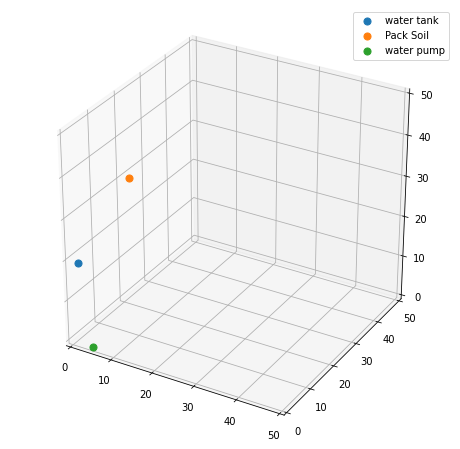

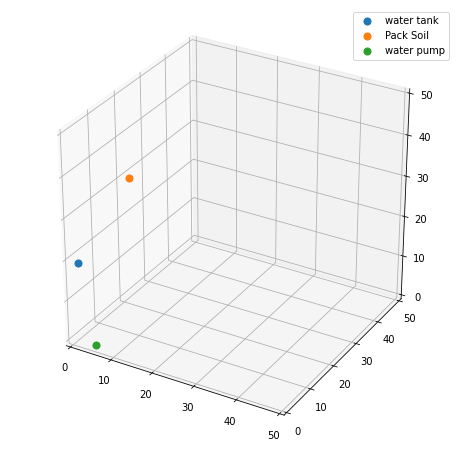

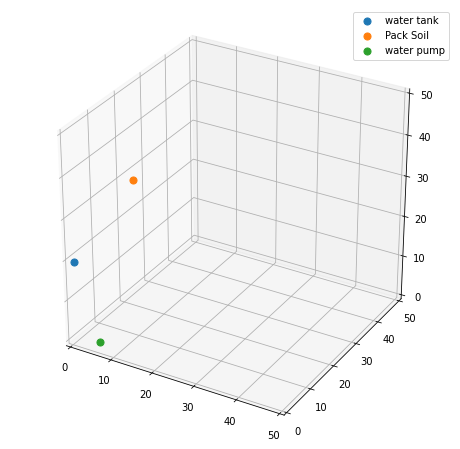

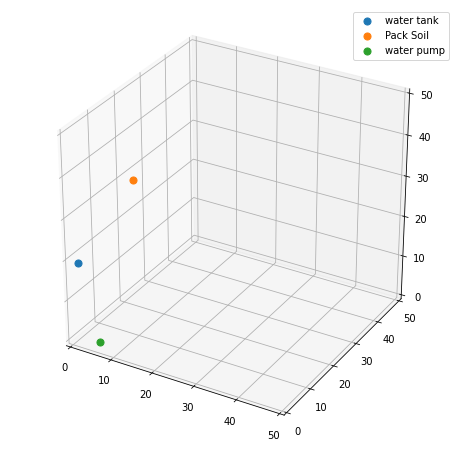

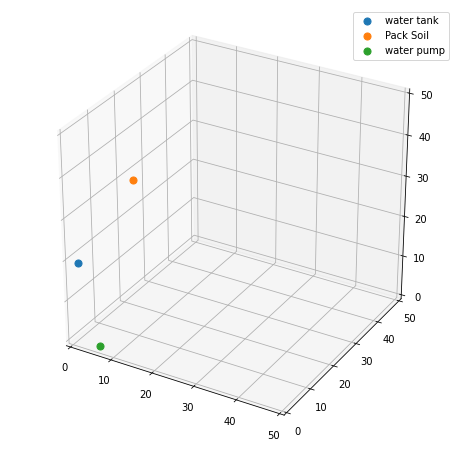

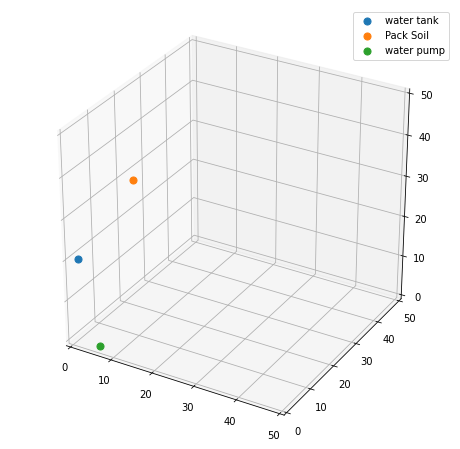

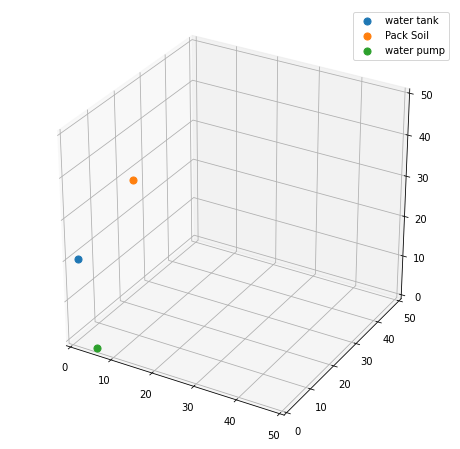

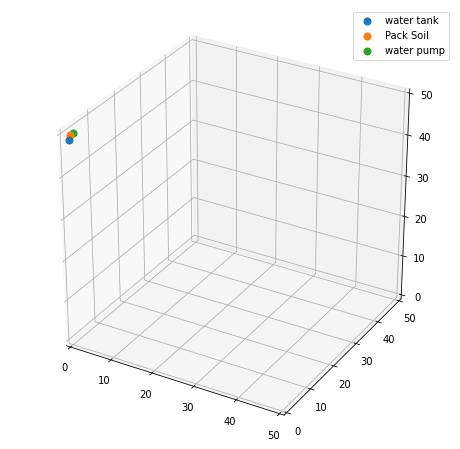

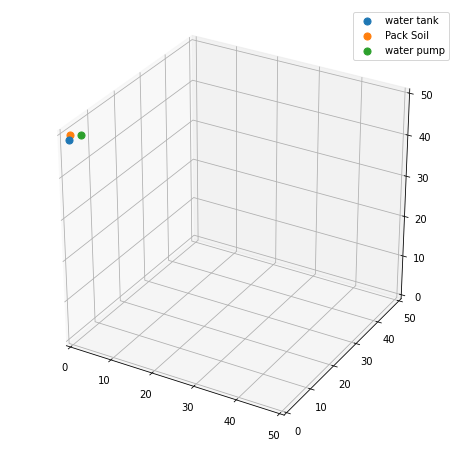

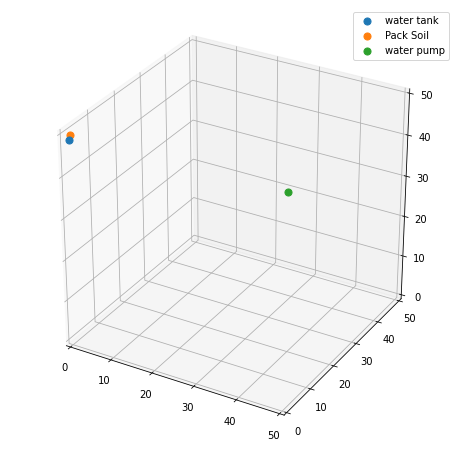

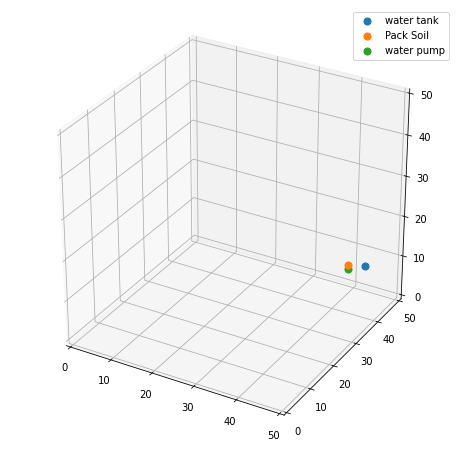

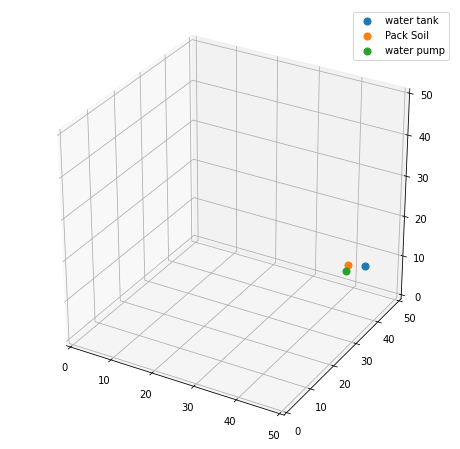

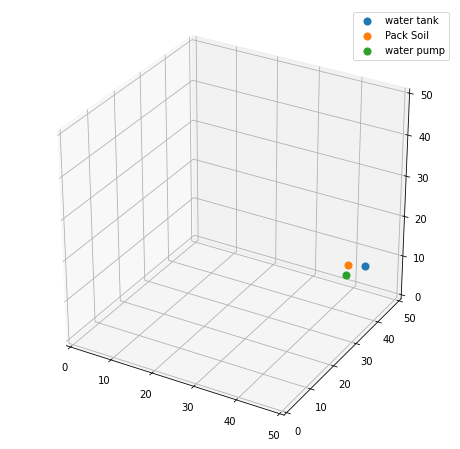

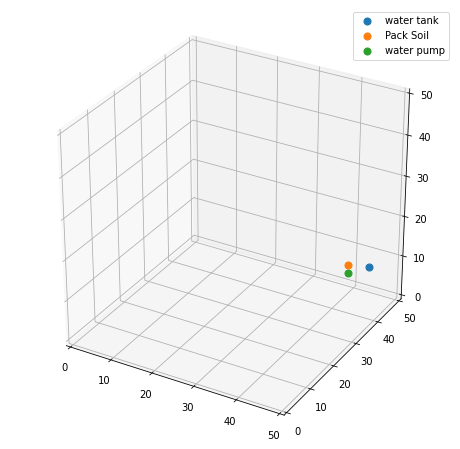

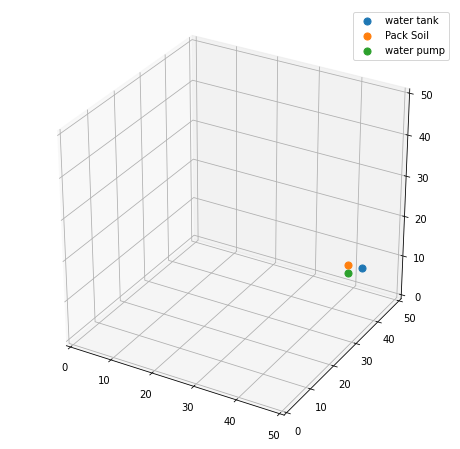

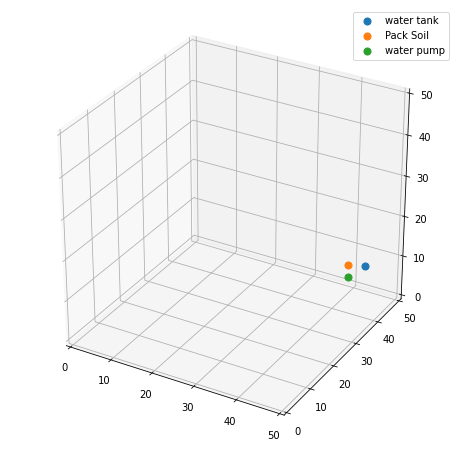

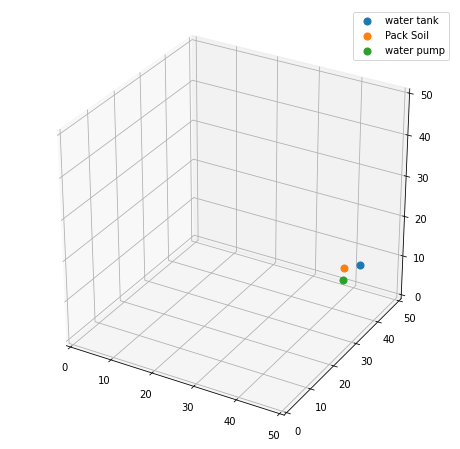

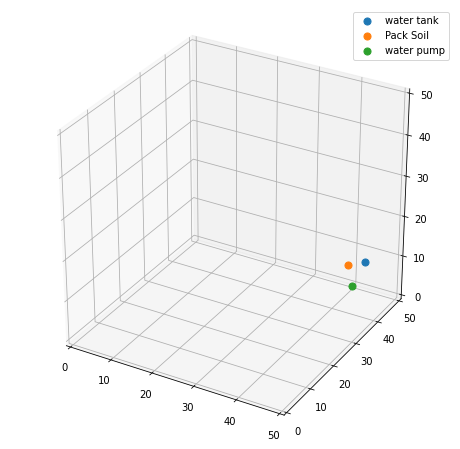

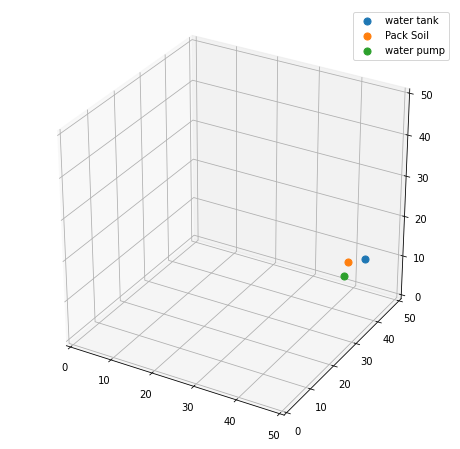

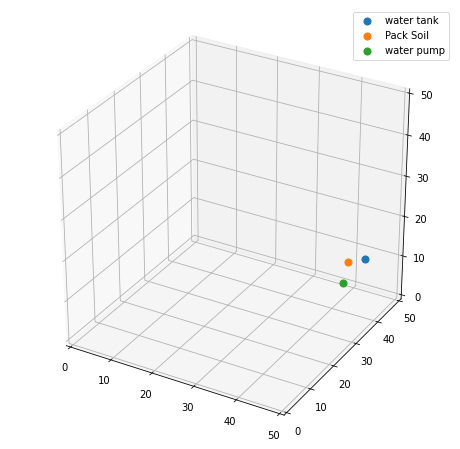

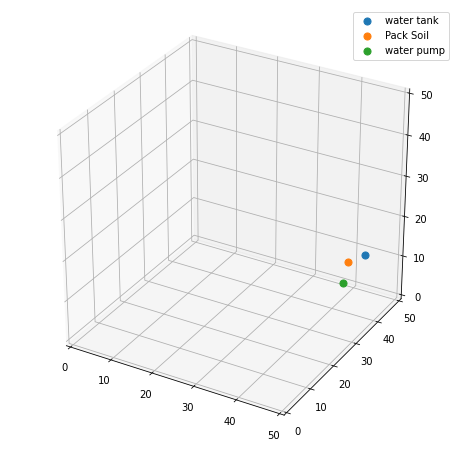

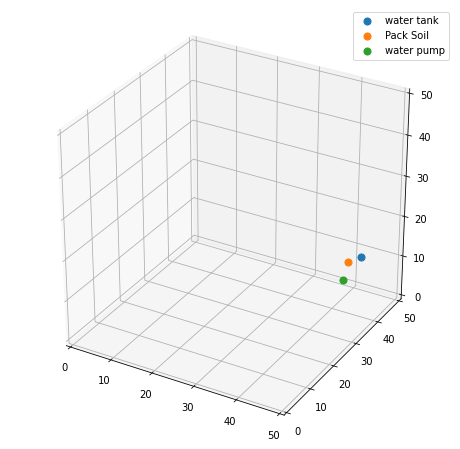

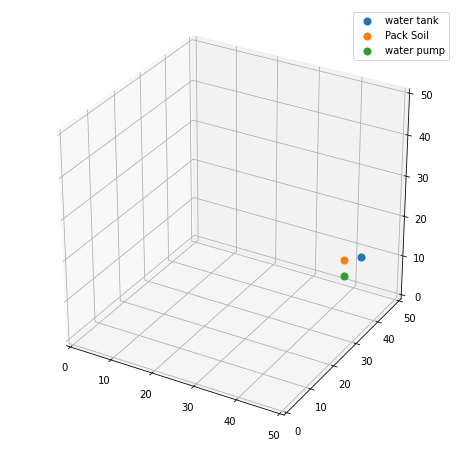

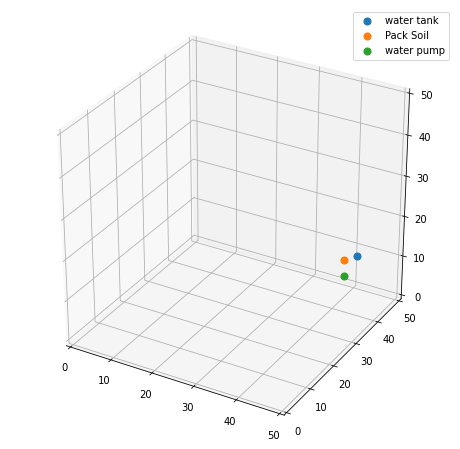

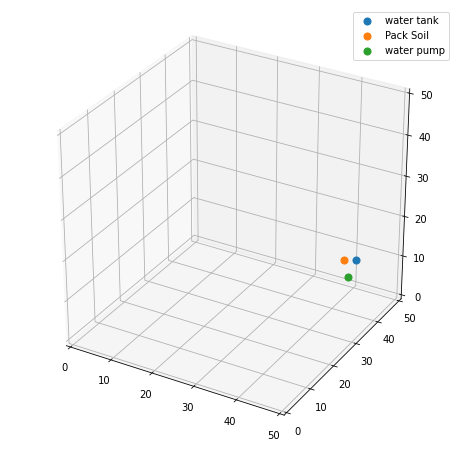

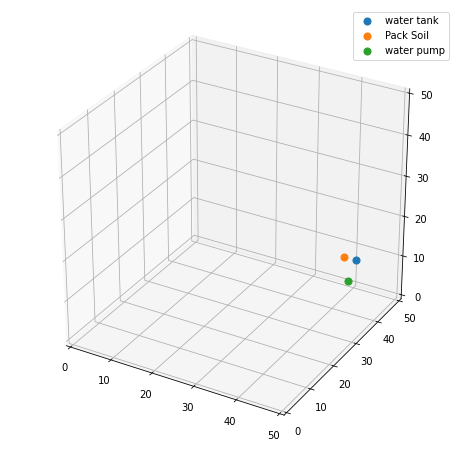

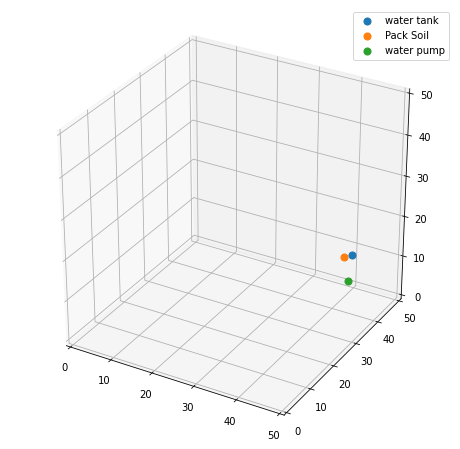

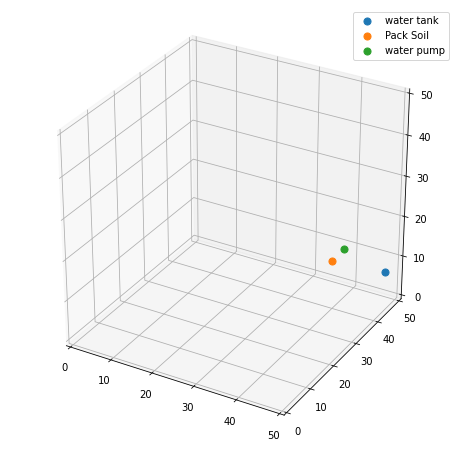

In [65]:
for i in range(len(comp)):

  fig = plt.figure(figsize=(8,8))

  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(comp[i][0][0],comp[i][0][1],comp[i][0][2], label='water tank', s=50)
  ax.scatter(comp[i][1][0],comp[i][1][1],comp[i][1][2], label='Pack Soil', s=50)
  ax.scatter(comp[i][2][0],comp[i][2][1],comp[i][2][2], label='water pump', s=50)
  ax.set_xlim3d(xmin=0,xmax=50)
  ax.set_ylim3d(ymin=0,ymax=50)
  ax.set_zlim3d(zmin=0,zmax=50)
  plt.legend()
  plt.show()
  #output.clear(wait=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The `zmin` argument was deprecated in Matplotlib 3.0 and will be removed

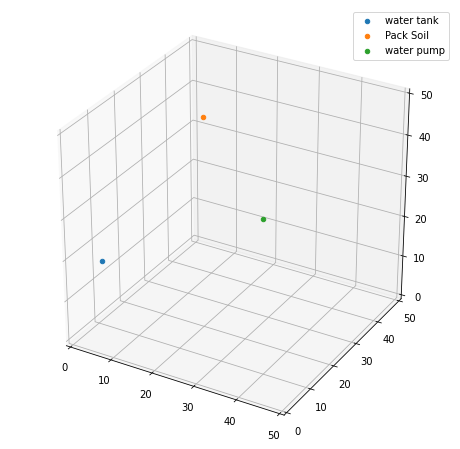

In [66]:
 orig = [[[4, 6, 18], [16, 27, 46], [24, 38, 18]]]
 

 for i in range(len(orig)):

  fig = plt.figure(figsize=(8,8))

  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(orig[i][0][0],orig[i][0][1],orig[i][0][2], label='water tank')
  ax.scatter(orig[i][1][0],orig[i][1][1],orig[i][1][2], label='Pack Soil')
  ax.scatter(orig[i][2][0],orig[i][2][1],orig[i][2][2], label='water pump')
  ax.set_xlim3d(xmin=0,xmax=50)
  ax.set_ylim3d(ymin=0,ymax=50)
  ax.set_zlim3d(zmin=0,zmax=50)
  plt.legend()
  plt.show()
  #output.clear(wait=True)

In [170]:
val[0]

[[30.106616201943194, 25.573423705088842],
 [25.66821042072284, 24.596747752497688],
 [25.314808684688682, 24.166091947189145],
 [17.73488351136175, 10.0],
 [15.352465904686959, 9.0]]

In [103]:
pareto_val = np.load('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front_val.npy', allow_pickle=True)
#/content/drive/MyDrive/DesignBot_Numpy3/pareto_front.npy
len(pareto_val[0])

23

In [72]:
pareto_val[0] = np.array(pareto_val[0])
pareto_val[0] = pareto_val[0].astype(int)
pareto_val[0]

array([[30, 20],
       [30, 20],
       [30, 19],
       [30, 19],
       [31, 20],
       [31, 21],
       [31, 21],
       [ 2,  3],
       [33, 48],
       [ 3,  4],
       [ 3,  4],
       [ 3,  5],
       [ 4,  5],
       [ 4,  5],
       [ 4,  6],
       [ 5,  7],
       [ 5,  7],
       [ 6,  9],
       [ 6, 10],
       [ 5,  8],
       [ 5,  7],
       [ 4,  6],
       [ 4,  5],
       [ 4,  6],
       [ 5,  7],
       [ 8, 10]])

In [104]:
pareto_val[1]

[[13.42534798940487, 18.027756377319946],
 [13.407180184183224, 17.11724276862369],
 [1.3333333333333333, 2.0],
 [1.1380711874576983, 1.7320508075688772],
 [1.5500938466242948, 2.23606797749979],
 [2.132781879222723, 3.1622776601683795],
 [2.0, 3.0],
 [9.3590878088035, 13.038404810405298],
 [8.726163587918359, 13.0],
 [7.333333333333333, 11.0],
 [7.37604118249516, 11.045361017187261],
 [4.502527434002323, 6.708203932499369],
 [3.9436506316151, 5.916079783099616],
 [4.353326162308409, 6.4031242374328485],
 [4.060594014630335, 6.082762530298219],
 [4.227909641151403, 6.324555320336759],
 [3.49071198499986, 5.385164807134504],
 [3.6191002540446946, 5.830951894845301],
 [5.575760139236095, 7.810249675906654],
 [5.577164208491297, 8.06225774829855],
 [5.424453433075509, 7.615773105863909],
 [6.343612241940889, 8.54400374531753],
 [6.778563594100414, 9.486832980505138],
 [8.27272070533004, 11.40175425099138],
 [3.0410352085392205, 5.0],
 [3.4073750464034815, 5.0990195135927845],
 [2.94939732

In [ ]:
pareto = np.load('/content/drive/MyDrive/DesignBot_Numpy3/pareto_front.npy', allow_pickle=True)
#/content/drive/MyDrive/DesignBot_Numpy3/pareto_front.npy
pareto

array([list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),
       list([119, 120, 121, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 122, 123, 124, 36, 37, 38, 125, 126, 127, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 18, 96, 97, 98, 99, 100, 101, 117, 118, 81, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 1, 39, 40, 41, 4

Text(0, 0.5, 'Objective 1')

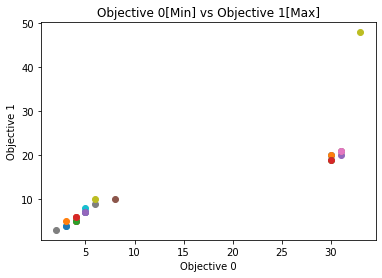

In [73]:
for i in range(len(pareto_val[0])):
  x = pareto_val[0][i][0]
  y = pareto_val[0][i][1]
  plt.scatter(x,y)
plt.title('Objective 0[Min] vs Objective 1[Max]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])

Text(0, 0.5, 'Objective 1')

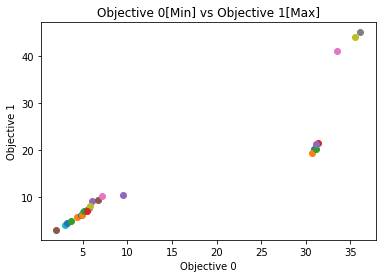

In [34]:
for i in range(len(pareto_val[1])):
  x = pareto_val[1][i][0]
  y = pareto_val[1][i][1]
  plt.scatter(x,y)
plt.title('Objective 0[Min] vs Objective 1[Max]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])

In [35]:
new_l = []
for p in pareto_val[0]:
  #print(p)
  print(p)
  if p not in pareto_val[1]:
    if p not in new_l:
      new_l.append(p)
  
      

[30.845148786531997, 20.223748416156685]
[30.88016441159432, 20.248456731316587]
[30.711021100238344, 19.672315572906]
[30.461971468587475, 19.44222209522358]
[31.112867407049592, 20.42057785666214]
[31.153298326764077, 21.400934559032695]
[31.14181301760613, 21.37755832643195]
[2.0, 3.1622776601683795]
[33.36731795130189, 48.093658625644196]
[3.0410352085392205, 4.47213595499958]
[3.198413860205747, 4.58257569495584]
[3.707701875205887, 5.0990195135927845]
[4.309990469479362, 5.830951894845301]
[4.259986625036681, 5.656854249492381]
[4.62508673081081, 6.4031242374328485]
[5.310109690569938, 7.615773105863909]
[5.468497085507965, 7.810249675906654]
[6.05782691187833, 9.433981132056603]
[6.6629598724514665, 10.295630140987]
[5.588942845785108, 8.06225774829855]
[5.227746168642519, 7.211102550927978]
[4.771251735987787, 6.708203932499369]
[4.2235160309735145, 5.385164807134504]
[4.494728106909096, 6.324555320336759]
[5.129966106554495, 7.0710678118654755]
[8.842809186432477, 10.440306508

In [109]:
p0 = []
p1 = []
for el in new_l:
  if (p not in pareto_val[1]) and (p in pareto_val[0]):
    p0.append('true')



In [ ]:
p0

[]

Text(0, 0.5, 'Objective 1')

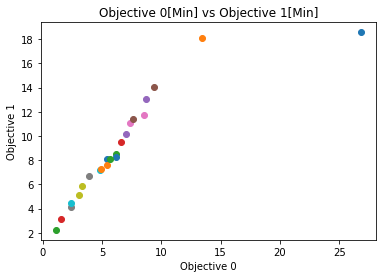

In [139]:
for i in range(len(new_l)):
  x = new_l[i][0]
  y = new_l[i][1]
  plt.scatter(x,y)
plt.title('Objective 0[Min] vs Objective 1[Min]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])

In [36]:
len(new_l)

26

In [38]:
new_l

[[30.845148786531997, 20.223748416156685],
 [30.88016441159432, 20.248456731316587],
 [30.711021100238344, 19.672315572906],
 [30.461971468587475, 19.44222209522358],
 [31.112867407049592, 20.42057785666214],
 [31.153298326764077, 21.400934559032695],
 [31.14181301760613, 21.37755832643195],
 [2.0, 3.1622776601683795],
 [33.36731795130189, 48.093658625644196],
 [3.0410352085392205, 4.47213595499958],
 [3.198413860205747, 4.58257569495584],
 [3.707701875205887, 5.0990195135927845],
 [4.309990469479362, 5.830951894845301],
 [4.259986625036681, 5.656854249492381],
 [4.62508673081081, 6.4031242374328485],
 [5.310109690569938, 7.615773105863909],
 [5.468497085507965, 7.810249675906654],
 [6.05782691187833, 9.433981132056603],
 [6.6629598724514665, 10.295630140987],
 [5.588942845785108, 8.06225774829855],
 [5.227746168642519, 7.211102550927978],
 [4.771251735987787, 6.708203932499369],
 [4.2235160309735145, 5.385164807134504],
 [4.494728106909096, 6.324555320336759],
 [5.129966106554495, 7.0

9.492903773105283
10.44030650891055


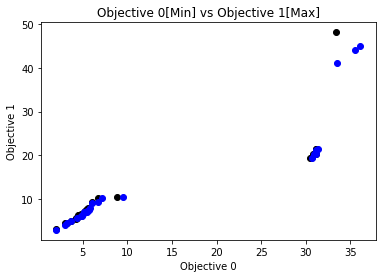

In [37]:
a=[]

for i in range(len(pareto_val[0])):
  x = pareto_val[0][i][0]
  
  y = pareto_val[0][i][1]
  plt.scatter(x,y,c='black')


for i in range(len(pareto_val[1])):
  x = pareto_val[1][i][0]
  y = pareto_val[1][i][1]
  plt.scatter(x,y,c='blue')
plt.title('Objective 0[Min] vs Objective 1[Max]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([int(max(x)),int(max(x)),int(max(y)),int(max(y))])
print(x)
print(y)

Text(0, 0.5, 'Objective 1')

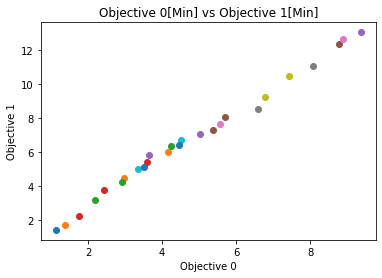

In [113]:
for i in range(len(pareto_val[2])):
  x = pareto_val[2][i][0]
  y = pareto_val[2][i][1]
  plt.scatter(x,y)
plt.title('Objective 0[Min] vs Objective 1[Min]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])

In [ ]:
pareto_rem = np.load('/content/drive/MyDrive/DesignBot_Numpy3/pareto_rem.npy')
len(pareto_rem)

FileNotFoundError: ignored

In [39]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(1)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(1)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(1)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(1)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(1)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')


In [65]:
best_d

array([20.49075582, 20.10772267, 20.10772267, ...,  4.76904526,
        4.76904526,  4.76904526])

Text(0.5, 1.0, 'Best distance over first 500 steps [component 1]')

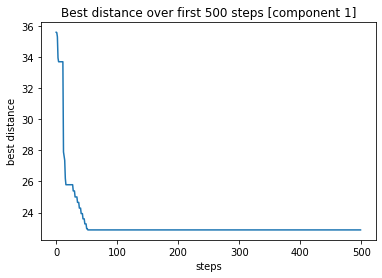

In [40]:
plt.plot(best_d[0:500])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 500 steps [component 1]')

Text(0.5, 1.0, 'Best distance over all steps[component 1]')

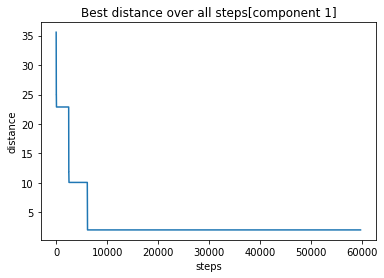

In [41]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 1]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 1')

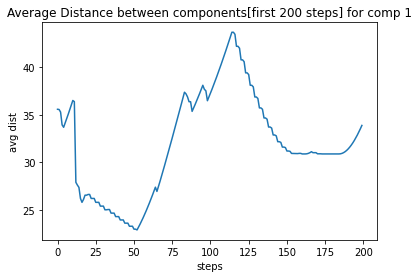

In [42]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 1')

Text(0.5, 1.0, 'Average Distance between components - comp1')

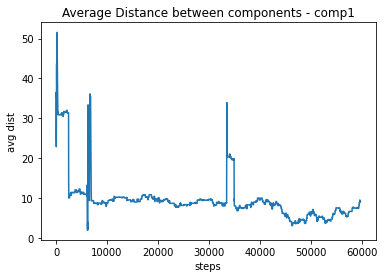

In [43]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp1')

In [44]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 1')

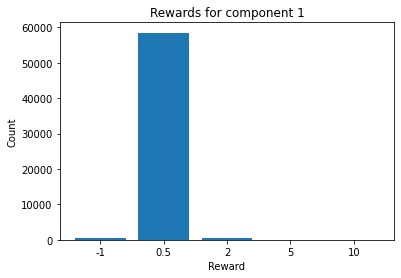

In [45]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 1')

Text(0.5, 1.0, 'Rewards for component 1')

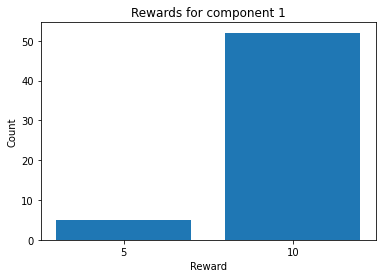

In [46]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 1')

Text(0.5, 1.0, 'Exploit vs Explore for component 1')

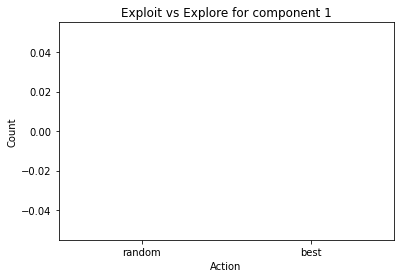

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 1')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')


Text(0.5, 1.0, 'Best distance over first 100 steps [component 2]')

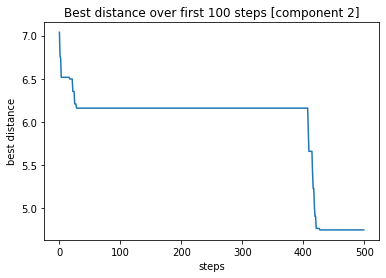

In [ ]:
plt.plot(best_d[0:500])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 2]')

Text(0.5, 1.0, 'Best distance over all steps[component 2]')

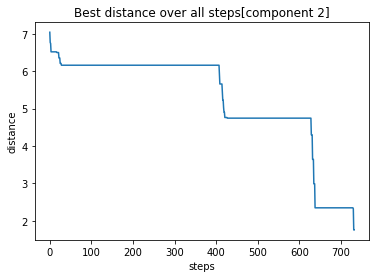

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 2]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 2')

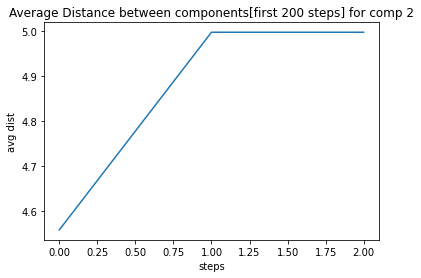

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 2')

Text(0.5, 1.0, 'Average Distance between components - comp 2')

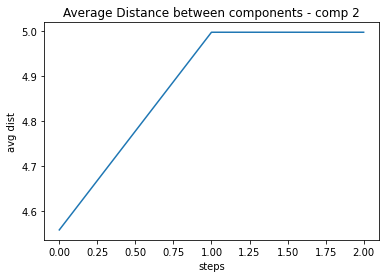

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 2')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 2')

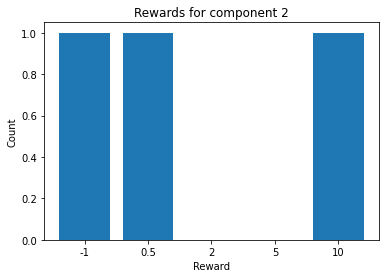

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 2')

Text(0.5, 1.0, 'Rewards for component 2')

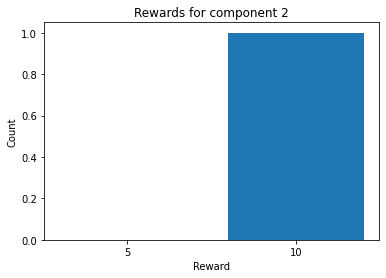

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 2')

Text(0.5, 1.0, 'Exploit vs Explore for component 2')

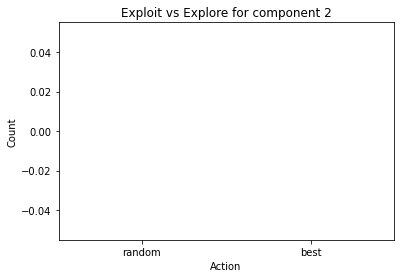

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 2')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(7)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(7)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(7)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(7)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(7)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 500 steps [component 7]')

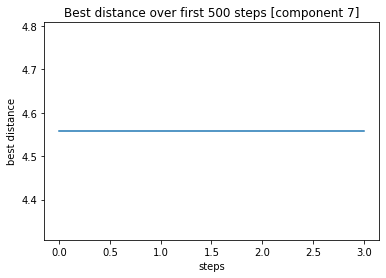

In [ ]:
plt.plot(best_d[0:500])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 500 steps [component 7]')

Text(0.5, 1.0, 'Best distance over all steps[component 7]')

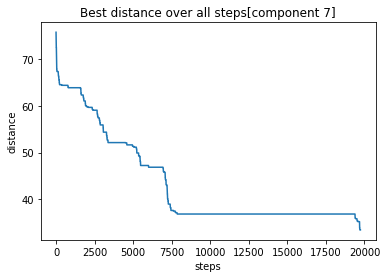

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 7]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 7')

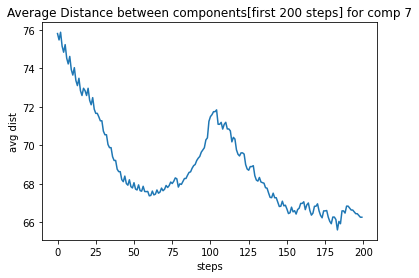

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 7')

Text(0.5, 1.0, 'Average Distance between components - comp 7')

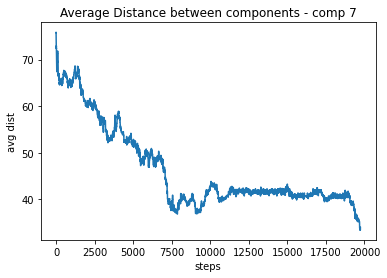

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 7')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 7')

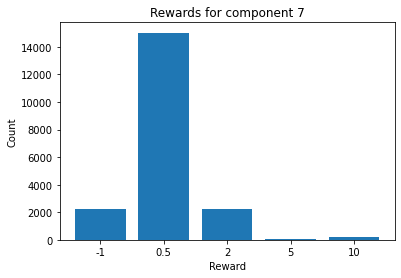

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 7')

Text(0.5, 1.0, 'Rewards for component 7')

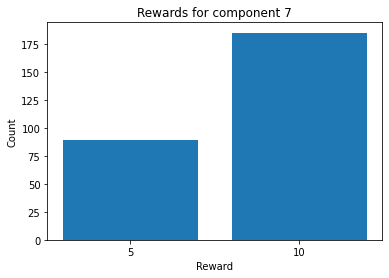

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 7')

Text(0.5, 1.0, 'Exploit vs Explore for component 7')

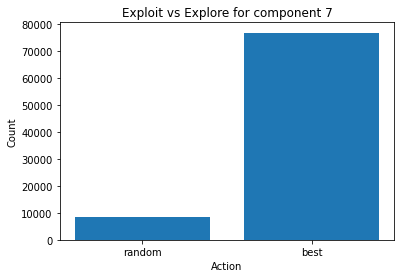

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 7')

In [47]:
reward_best_d_file_name = 'best_d_glog'+str(1)+'_'+str(1)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(1)+'_'+str(1)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(1)+'_'+str(1)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(1)+'_'+str(1)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(1)+'_'+str(1)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 0]')

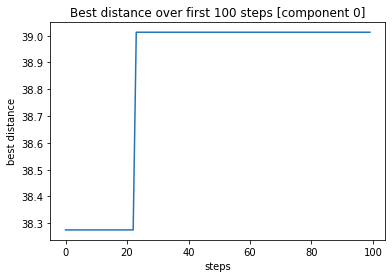

In [48]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 0]')

Text(0.5, 1.0, 'Best distance over all steps[component 0]')

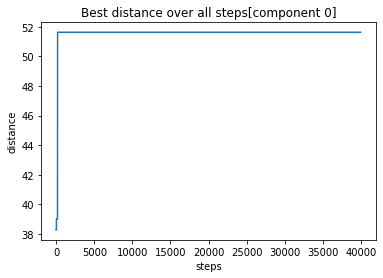

In [49]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 0]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 0')

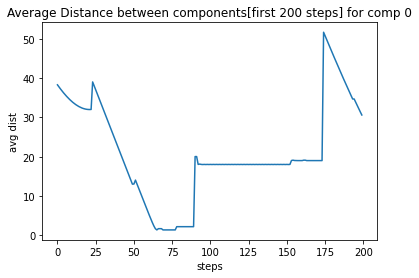

In [50]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 0')

Text(0.5, 1.0, 'Average Distance between components - comp 0')

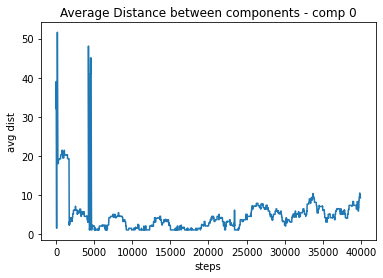

In [51]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 0')

In [52]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 0')

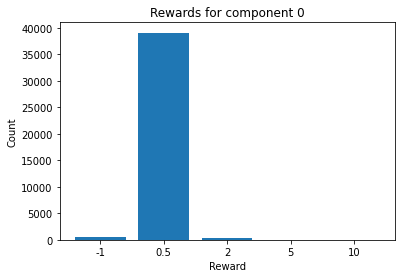

In [53]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 0')

Text(0.5, 1.0, 'Rewards for component 0')

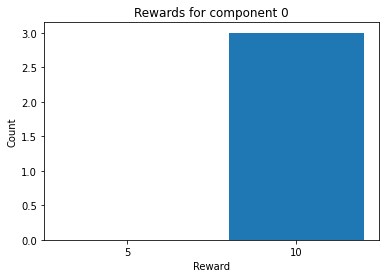

In [54]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 0')

Text(0.5, 1.0, 'Exploit vs Explore for component 0')

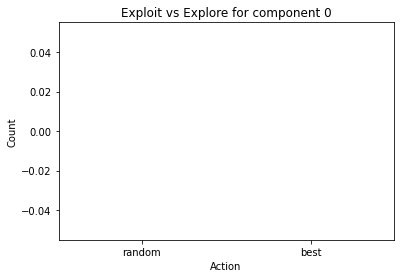

In [55]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 0')

In [56]:
reward_best_d_file_name = 'best_d_glog'+str(1)+'_'+str(5)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(1)+'_'+str(5)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(1)+'_'+str(5)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(1)+'_'+str(5)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(1)+'_'+str(5)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

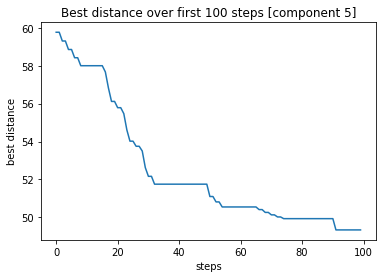

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

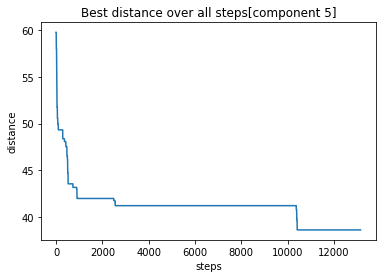

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

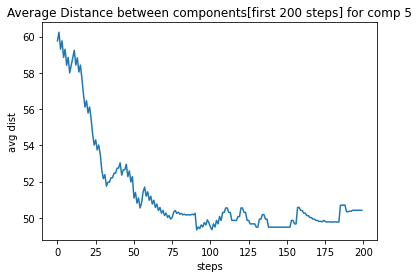

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

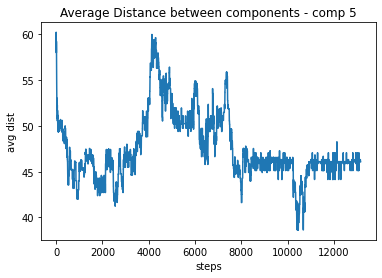

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

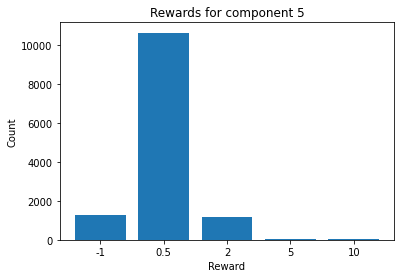

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

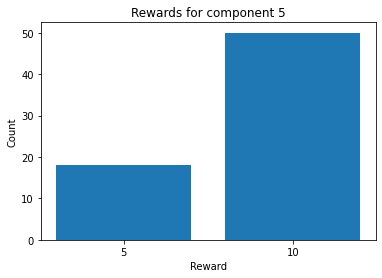

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

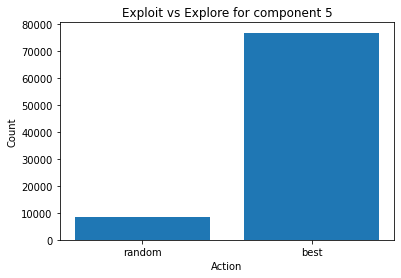

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(2)+'_'+str(3)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(2)+'_'+str(3)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(2)+'_'+str(3)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(2)+'_'+str(3)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(2)+'_'+str(3)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

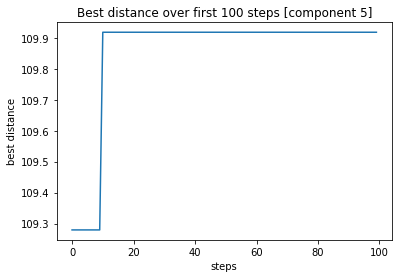

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

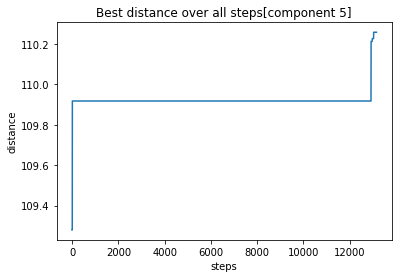

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

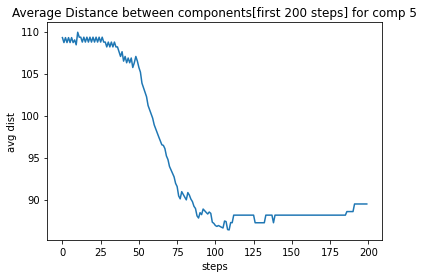

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

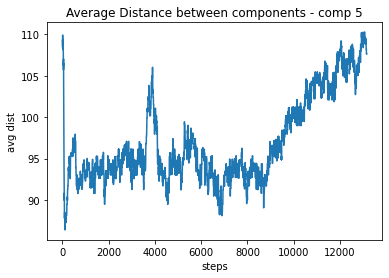

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

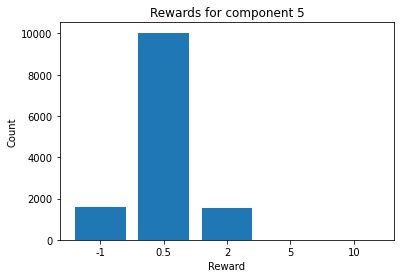

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

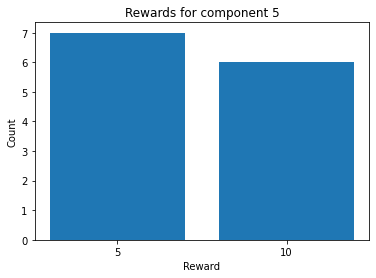

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

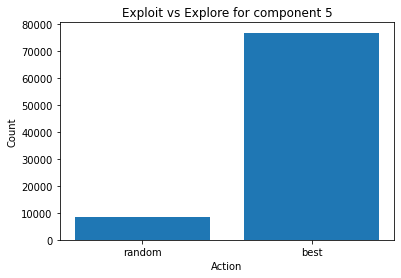

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(2)+'_'+str(6)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(2)+'_'+str(6)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(2)+'_'+str(6)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(2)+'_'+str(6)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(2)+'_'+str(6)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

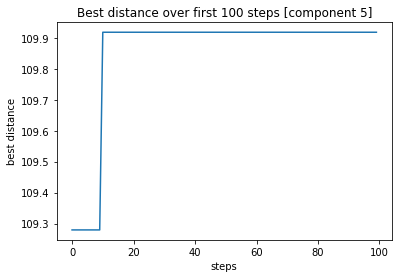

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

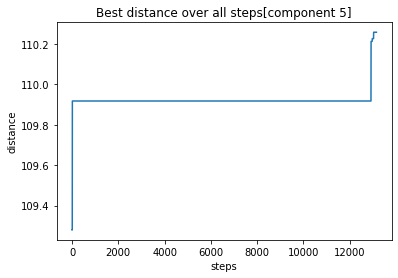

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

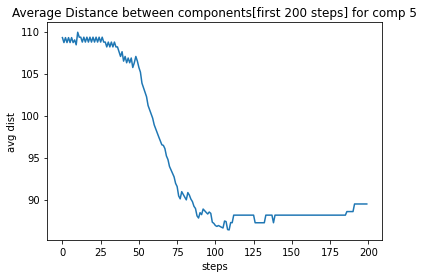

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

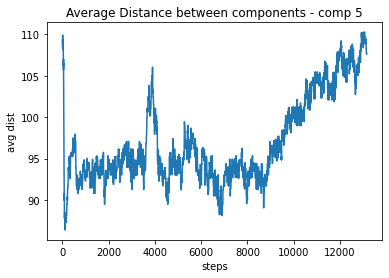

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

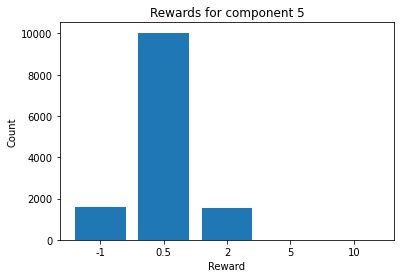

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

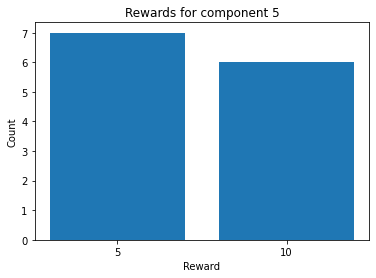

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

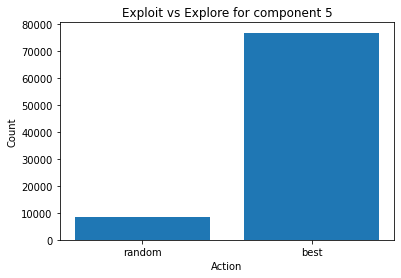

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(3)+'_'+str(3)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(3)+'_'+str(3)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(3)+'_'+str(3)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(3)+'_'+str(3)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(3)+'_'+str(3)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

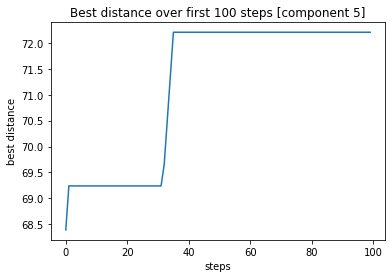

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

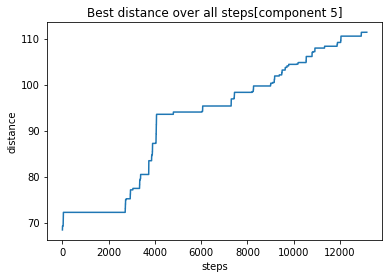

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

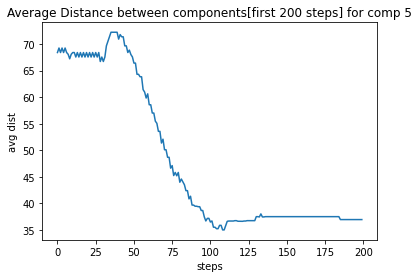

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

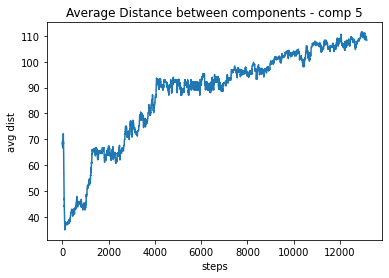

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

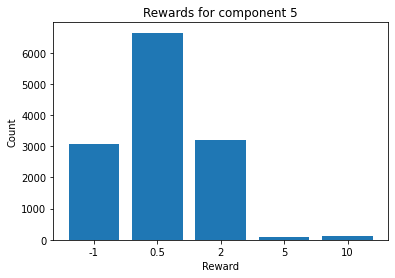

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

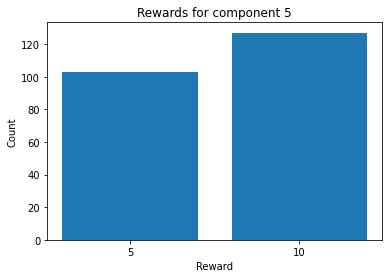

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

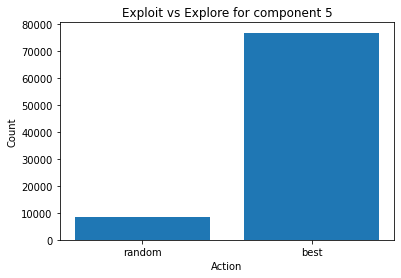

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(3)+'_'+str(0)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(3)+'_'+str(0)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(3)+'_'+str(0)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(3)+'_'+str(0)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(3)+'_'+str(0)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

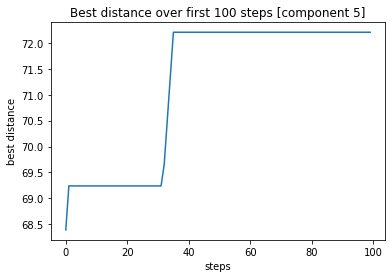

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

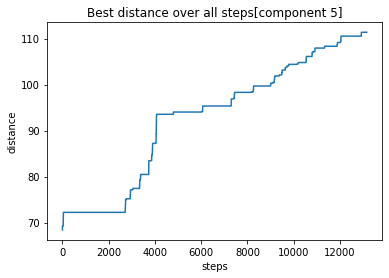

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

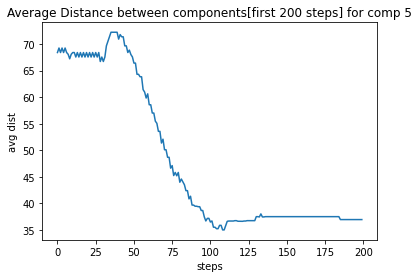

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

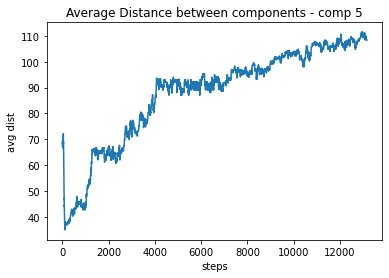

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

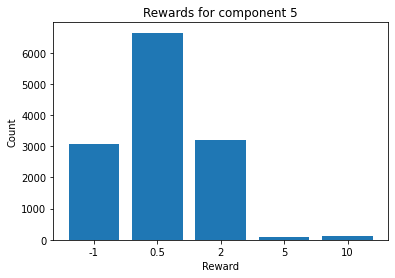

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

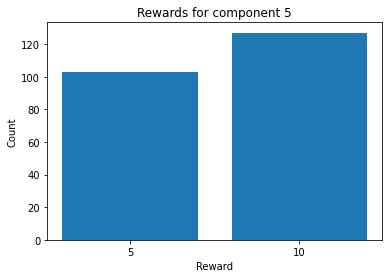

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

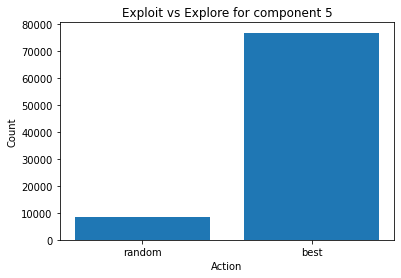

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(4)+'_'+str(6)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(4)+'_'+str(6)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(4)+'_'+str(6)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(4)+'_'+str(6)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(4)+'_'+str(6)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

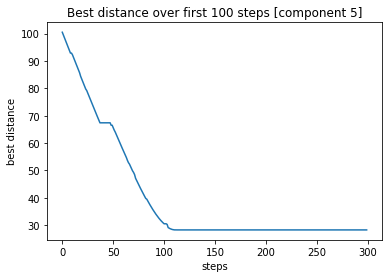

In [ ]:
plt.plot(best_d[0:300])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

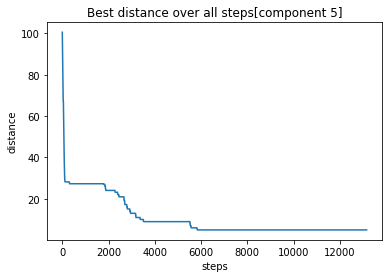

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

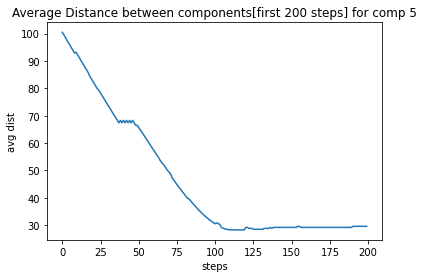

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

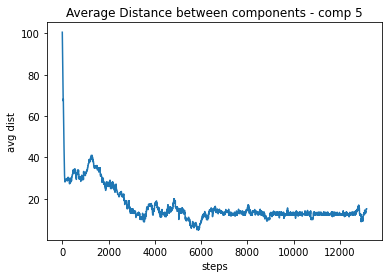

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

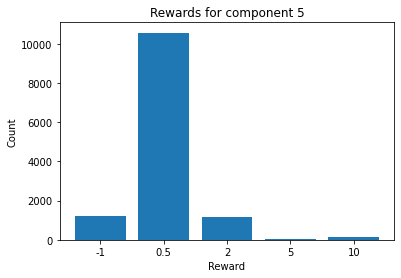

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

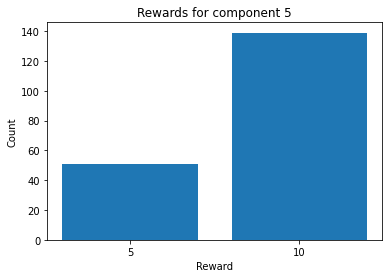

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

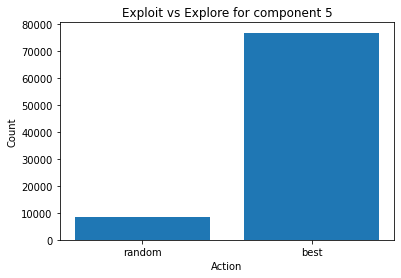

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(4)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(4)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(4)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(4)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(4)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

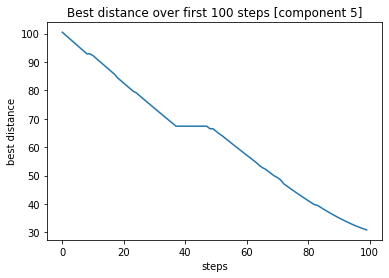

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

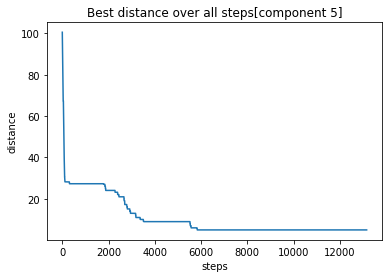

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

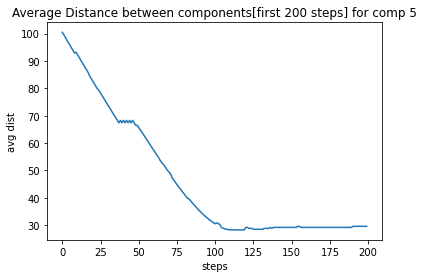

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

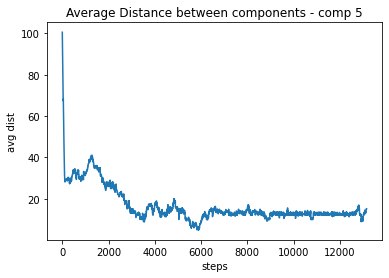

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

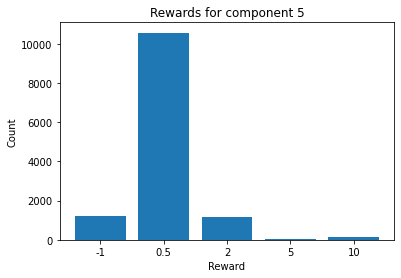

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

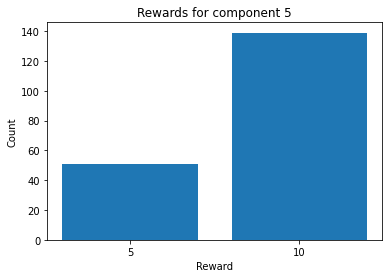

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

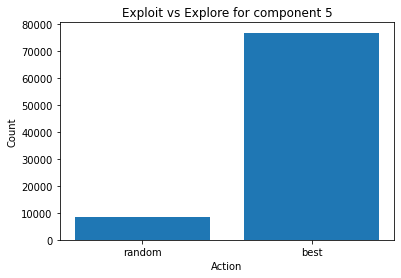

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(5)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(5)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(5)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(5)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(5)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

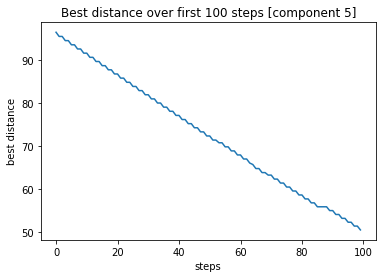

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

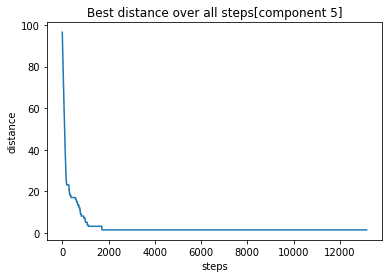

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

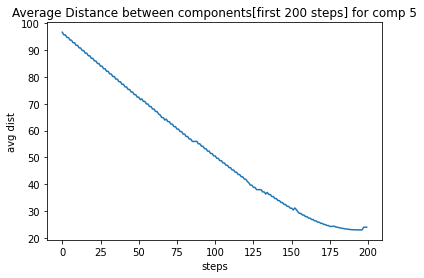

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

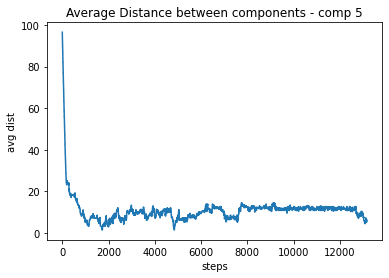

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

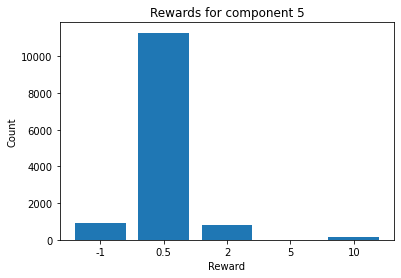

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

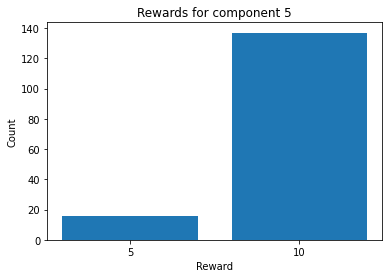

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

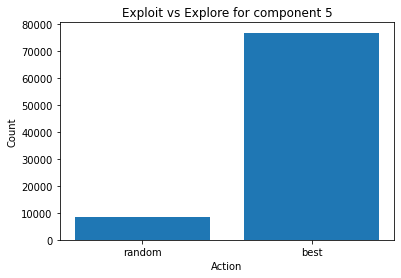

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(5)+'_'+str(4)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(5)+'_'+str(4)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(5)+'_'+str(4)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(5)+'_'+str(4)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(5)+'_'+str(4)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy3/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

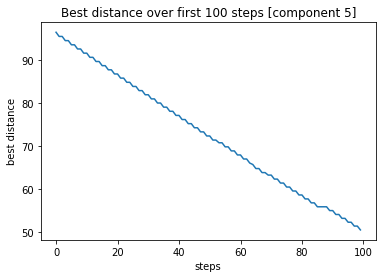

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

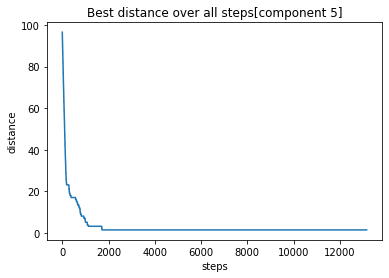

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

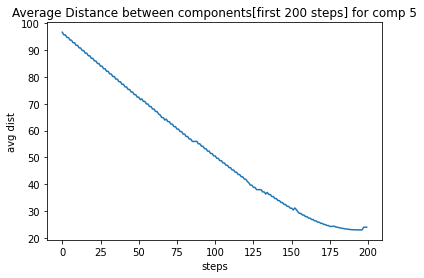

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

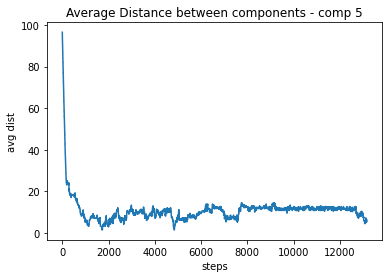

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

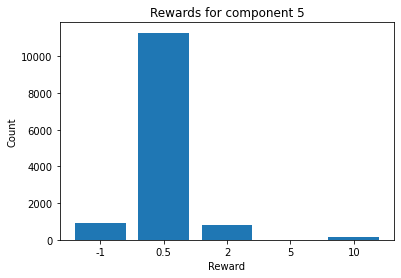

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

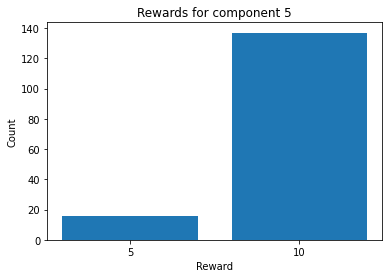

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

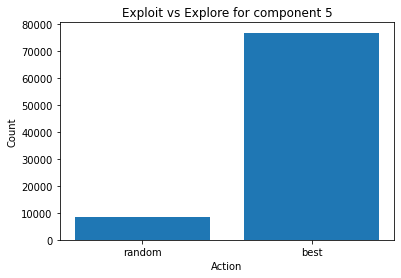

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')